# Insurance & Natural Disasters Knowledge Graph Analysis

This notebook demonstrates analytical queries against the Insurance & Natural Disasters Knowledge Graph which we loaded in [loader.ipynb](loader.ipynb).

## Prerequisites

To run this notebook, ensure you have:

1. Loaded data using `loader.ipynb`
2. Valid Neo4j credentials in your `.env` file

## The Analysis

We will perform a number of analytical queries to extract insights from the knowledge graph. Many will be recognisable by insurance professionals working with natural disaster risk and insurance data, but we will also include explanations for those less familiar with the domain.

Let's start by defining some helper methods which we will use throughout the notebook to run queries and visualize results.

In [47]:
# Environment Setup
import os
from dotenv import load_dotenv
from neo4j import GraphDatabase, Result
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.patches import Patch
from shapely.geometry import box
from playwright.async_api import async_playwright

load_dotenv()

NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")
ISO_A3_COUNTRY_CODE = os.getenv("ISO_A3_COUNTRY_CODE")
USD_TO_EUR = float(os.getenv("USD_TO_EUR"))


class Neo4jAnalysis:
    """Helper class to consolidate Neo4j query and visualization functionality."""
    
    # Standard color palette for risk maps (Blue/Green → Yellow → Orange → Red)
    FLOOD_COLORS = ['#2166ac', '#67a9cf', '#d1e5f0', '#ffffbf', '#fddbc7', '#f4a582', '#d6604d', '#b2182b']
    
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database
    
    def close(self):
        """Close the Neo4j driver connection."""
        self.driver.close()
    
    def run_query(self, query, params=None):
        """Execute a Cypher query and return results as a list of dictionaries."""
        with self.driver.session(database=self.database) as session:
            result = session.run(query, params or {})
            return [record.data() for record in result]
    
    def run_query_df(self, query, params=None):
        """Execute a Cypher query and return results as a pandas DataFrame."""
        records = self.run_query(query, params)
        return pd.DataFrame(records)
    
    def run_query_single(self, query, params=None):
        """Execute a Cypher query and return a single record."""
        with self.driver.session(database=self.database) as session:
            result = session.run(query, params or {})
            return result.single()
        
    def run_query_viz(self, query, params=None):
        result = self.driver.execute_query(
            query,
            parameters_=params or {},
            database_=self.database,
            result_transformer_=Result.graph,
        )
        return result

    async def capture_graph_to_png(self, html_content, output_path, scale=2, width=1920, height=1080):
        """
        Capture a graph visualization to a PNG file with configurable resolution.
        
        Args:
            html_content: The HTML content from neo4j_viz render()
            output_path: Path to save the PNG file
            scale: Device scale factor for higher resolution (default: 2 for 2x/Retina quality)
            width: Viewport width in pixels (default: 1920)
            height: Viewport height in pixels (default: 1080)
        """
        # Inject CSS to center the graph and fill the viewport
        centering_css = """
        <style>
            html, body {
                margin: 0;
                padding: 0;
                width: 100%;
                height: 100%;
                overflow: hidden;
            }
            body > div, canvas, #graph-container, .nvg-container {
                width: 100% !important;
                height: 100% !important;
                display: flex;
                justify-content: center;
                align-items: center;
            }
        </style>
        """
        # Insert centering CSS into the HTML content
        html_data = html_content.data
        if '<head>' in html_data:
            html_data = html_data.replace('<head>', f'<head>{centering_css}')
        else:
            html_data = centering_css + html_data
        
        # Save content to a temporary HTML file
        with open("remove.html", "w", encoding="utf-8") as f:
            f.write(html_data)
        async with async_playwright() as p:
            # Launch a headless browser
            browser = await p.chromium.launch()
            # Create page with higher resolution viewport and device scale factor
            page = await browser.new_page(
                viewport={'width': width, 'height': height},
                device_scale_factor=scale
            )
            
            # Load the local HTML file
            abs_path = f"file://{os.path.abspath('remove.html')}"
            await page.goto(abs_path)
            
            # Wait for the force-directed layout to stabilize
            await page.wait_for_timeout(8000) 
            
            # Take screenshot of just the viewport (not full_page) for centered output
            await page.screenshot(path=output_path, full_page=False)
            await browser.close()
        # Clean up the temporary file
        os.remove("remove.html")
    
    def verify_connection(self):
        """Verify the Neo4j connection is working."""
        record = self.run_query_single("RETURN 1 AS test")
        return record and record['test'] == 1
    
    def get_risk_cmap(self, n_bins=256):
        """Get the standard risk colormap (Blue → Yellow → Orange → Red)."""
        return LinearSegmentedColormap.from_list('flood_risk', self.FLOOD_COLORS, N=n_bins)
    
    @staticmethod
    def currency_fmt(x, pos):
        """Format currency values for map legends."""
        if x >= 1e9:
            return f'€{x/1e9:.1f}B'
        elif x >= 1e6:
            return f'€{x/1e6:.1f}M'
        elif x >= 1e3:
            return f'€{x/1e3:.0f}K'
        else:
            return f'€{x:.0f}'
    
    def fetch_nuts3_geometries(self, url=None):
        """Fetch NUTS3 geometries from Eurostat GISCO services."""
        if url is None:
            url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_03M_2021_3857_LEVL_3.geojson"
        print("Fetching NUTS3 geometries...")
        return gpd.read_file(url)
    
    def plot_choropleth_map(self, gdf, column, title, ax=None, cmap=None, 
                            legend_label=None, alpha=0.7, edgecolor='black', 
                            linewidth=0.5, log_scale=False, add_basemap=True,
                            label_top_n=None, label_column=None, label_format=None,
                            norm=None, label_func=None, label_bbox_color='black'):
        """
        Create a choropleth map visualization.
        
        Args:
            gdf: GeoDataFrame with geometries and data
            column: Column name to visualize
            title: Map title
            ax: Matplotlib axes (creates new figure if None)
            cmap: Colormap (uses default risk colormap if None)
            legend_label: Label for the legend
            alpha: Transparency (0-1)
            edgecolor: Color for region borders
            linewidth: Width of region borders
            log_scale: Use logarithmic color scale
            add_basemap: Add CartoDB basemap
            label_top_n: Number of top regions to label
            label_column: Column to use for labeling (defaults to NUTS_ID)
            label_format: Format string for label values
            norm: Matplotlib Normalize instance for consistent color scaling
            label_func: Custom function(row) -> str for label text
            label_bbox_color: Background color for labels
        """
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        if cmap is None:
            cmap = self.get_risk_cmap()
        
        plot_kwargs = {
            'column': column,
            'ax': ax,
            'cmap': cmap,
            'legend': True,
            'legend_kwds': {
                'label': legend_label or column,
                'format': ticker.FuncFormatter(self.currency_fmt),
                'shrink': 0.8
            },
            'alpha': alpha,
            'edgecolor': edgecolor,
            'linewidth': linewidth
        }
        
        # Use provided norm, or create log scale norm if requested
        if norm is not None:
            plot_kwargs['norm'] = norm
        elif log_scale:
            plot_kwargs['norm'] = LogNorm(
                vmin=gdf[column].min(), 
                vmax=gdf[column].max()
            )
        
        gdf.plot(**plot_kwargs)
        
        if add_basemap:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)
        
        # Add labels for top regions
        if label_top_n and label_top_n > 0:
            top_regions = gdf.nlargest(label_top_n, column)
            id_col = label_column or 'NUTS_ID'
            for idx, row in top_regions.iterrows():
                # Use custom label function if provided
                if label_func:
                    label_text = label_func(row)
                elif label_format and column in row:
                    label_text = f"{row[id_col]}\n{label_format.format(row[column])}"
                else:
                    label_text = row[id_col]
                ax.annotate(
                    text=label_text,
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=7, color='white', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor=label_bbox_color, alpha=0.7)
                )
        
        ax.set_axis_off()
        ax.set_title(title, fontsize=14)
        return ax
    
    def create_cell_polygons(self, df, lat_col='latitude', lon_col='longitude', 
                              cell_size=1/120):
        """
        Convert point data to cell polygons for grid visualization.
        
        Args:
            df: DataFrame with latitude and longitude columns
            lat_col: Name of latitude column
            lon_col: Name of longitude column
            cell_size: Size of each cell in degrees (default: 30 arc-seconds)
        
        Returns:
            GeoDataFrame with polygon geometries
        """
        geometry = [
            box(lon - cell_size/2, lat - cell_size/2, 
                lon + cell_size/2, lat + cell_size/2)
            for lon, lat in zip(df[lon_col], df[lat_col])
        ]
        return gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')


# Initialize the analysis helper
analysis = Neo4jAnalysis(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, NEO4J_DATABASE)

# Verify connection
if analysis.verify_connection():
    print("Neo4j connection successful!")
else:
    print("Neo4j connection failed!")

# Keep the driver reference for backward compatibility
driver = analysis.driver

Neo4j connection successful!


## The Graph Schema

To understand the queries and use cases we will explore, it's helpful to have a quick overview of the graph schema we created in [loader.ipynb](loader.ipynb). The main node labels and their relationships are as follows.

In [48]:
from neo4j_viz.neo4j import from_neo4j, ColorSpace

# Plot schema visualization
schema = """
CALL apoc.meta.graph()
"""

schema_result = analysis.run_query_viz(schema)
VG = from_neo4j(schema_result)
VG.color_nodes(
    field="caption", # Using the internal labels property
    color_space=ColorSpace.DISCRETE,
    colors={
        "Country": "#1f77b4",              # Blue for Countries
        "Region": "#ff7f0e",               # Orange for Regions
        "InsuranceMetric": "#2ca02c",      # Green for Insurance Metrics
        "LossEvent": "#d62728",            # Red for Loss Events
        "LossEventImpact": "#9467bd",      # Purple for Loss Event Impacts
        "EconomicExposureCell": "#8c564b", # Brown for Economic Exposure Cells
    },
)
generated_html = VG.render(layout="forcedirected", initial_zoom=1.9)

In [49]:
await analysis.capture_graph_to_png(generated_html, "renderings/schema_graph.png")

![Graph Schema](./renderings/schema_graph.png)

To get a better understanding of our graph architecture, we can also visualize a sample subgraph for a random NUTS3 region, showing the region hierarchy, insurance metrics, and a sample of economic exposure cells.

In [50]:
# Visualize the graph for a random NUTS3 region
# Shows: Region hierarchy, insurance metrics, and a sample of economic exposure cells

sample_query = """
// Pick a random NUTS3 region from the country
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF]-(nuts1:Region {level: 1})
      <-[:PART_OF]-(nuts2:Region {level: 2})<-[:PART_OF]-(nuts3:Region {level: 3})
WITH country, nuts1, nuts2, nuts3, rand() AS r
ORDER BY r
LIMIT 1

// Get the region hierarchy path
MATCH path_hierarchy = (nuts3)-[:PART_OF]->(nuts2)-[:PART_OF]->(nuts1)-[:PART_OF]->(country)

// Get a few insurance metrics from the country (limit to avoid explosion)
OPTIONAL MATCH path_insurance = (country)-[rf:REPORTED_FINANCIALS]->(metric:InsuranceMetric)
WHERE rf.year = 2024
WITH country, nuts1, nuts2, nuts3, path_hierarchy, path_insurance
LIMIT 2

// Get a sample of economic exposure cells (limit to 5)
OPTIONAL MATCH path_cell = (cell:EconomicExposureCell)-[:LOCATED_IN]->(nuts3)
WITH country, nuts1, nuts2, nuts3, path_hierarchy, path_insurance, collect(path_cell)[0..5] AS cell_paths

// Get loss events impacting this region WITH their impacts in a single path
OPTIONAL MATCH path_event_full = (impact:LossEventImpact)<-[:HAS_IMPACT]-(event:LossEvent)-[:IMPACTED_REGION]->(nuts3)
WITH path_hierarchy, path_insurance, cell_paths, collect(path_event_full)[0..3] AS event_paths

// Return all paths
RETURN path_hierarchy, path_insurance, cell_paths, event_paths
"""

sample_result = analysis.run_query_viz(sample_query, {'country_code': ISO_A3_COUNTRY_CODE})

VG_sample = from_neo4j(sample_result)

# Set custom captions based on node type (using labels and properties)
for node in VG_sample.nodes:
    labels = node.properties.get("labels", [])
    props = node.properties
    
    if "Country" in labels:
        node.caption = props.get("name", props.get("iso_a3", "Country"))
    elif "Region" in labels:
        level = props.get("level", "")
        name = props.get("name", props.get("nuts_code", "Region"))
        node.caption = f"NUTS{level}: {name}"
    elif "InsuranceMetric" in labels:
        metric_name = props.get("name", "Metric")
        business = props.get("business_type", "")
        node.caption = f"{metric_name}\n({business})" if business else metric_name
    elif "LossEvent" in labels:
        hazard = props.get("hazard_type", "Event")
        year = props.get("year", "")
        node.caption = f"{hazard} ({year})" if year else hazard
    elif "LossEventImpact" in labels:
        metric = props.get("metric", "Impact")
        value = props.get("value", "")
        if value:
            node.caption = f"{metric}\n€{value/1e6:.1f}M" if value >= 1e6 else f"{metric}\n€{value:,.0f}"
        else:
            node.caption = metric
    elif "EconomicExposureCell" in labels:
        value = props.get("value", 0)
        node.caption = f"Cell\n${value/1e6:.2f}M" if value >= 1e6 else f"Cell\n${value:,.0f}"
    else:
        node.caption = str(node.id)

VG_sample.color_nodes(
    field="caption",
    color_space=ColorSpace.DISCRETE,
    colors={
        "Country": "#1f77b4",              # Blue for Countries
        "Region": "#ff7f0e",               # Orange for Regions
        "InsuranceMetric": "#2ca02c",      # Green for Insurance Metrics
        "LossEvent": "#d62728",            # Red for Loss Events
        "LossEventImpact": "#9467bd",      # Purple for Loss Event Impacts
        "EconomicExposureCell": "#8c564b", # Brown for Economic Exposure Cells
    },
)
generated_html = VG_sample.render(layout="forcedirected", initial_zoom=1.3)

In [51]:
await analysis.capture_graph_to_png(generated_html, "renderings/sample_region_graph.png")

![Sample Region Subgraph](./renderings/sample_region_graph.png)

In the sample above you can clearly see how the NUTS hierarchy is laid out (NUTS3 -> NUTS2 -> NUTS1 -> Country), how insurance metrics are connected to the country, and how economic exposure cells are connected to the NUTS3 region as well. This structure allows us to easily query and analyze insurance metrics and economic exposures at different levels of the regional hierarchy.

## Country-Level Insurance Metrics

Let's start our analysis by retrieving all reported financial metrics which we previously loaded from EIOPA datasets. This will give us an overview of the insurance landscape across the country of interest. We will later use these metrics to perform more complex analyses, such as risk estimation and loss event impact assessment.

We can easily query metrics at the country level by looking for nodes with the label `InsuranceMetric` that are connected to the country node. This will allow us to see all the different types of insurance metrics that have been reported for the country, such as total premiums, claims, and loss ratios. To illustrate this, let us visualise reported metrics for the years 2020 to 2024.

In [52]:
# Filter for the specific country
query_insurance_metrics_filtered = """
MATCH (c:Country {iso_a3: $country_code})-[r:REPORTED_FINANCIALS]->(m:InsuranceMetric)
WHERE r.year >= $start_year AND r.year <= $end_year
RETURN 
    c.name AS country,
    r.year AS year,
    m.name AS metric_name,
    m.business_type AS business_type,
    r.value AS value
ORDER BY r.year DESC, m.name
"""

# Set parameters
params = {
    'country_code': ISO_A3_COUNTRY_CODE,
    'start_year': 2020,
    'end_year': 2024
}

# Using the analysis helper class
df_insurance_metrics = analysis.run_query_df(query_insurance_metrics_filtered, params)

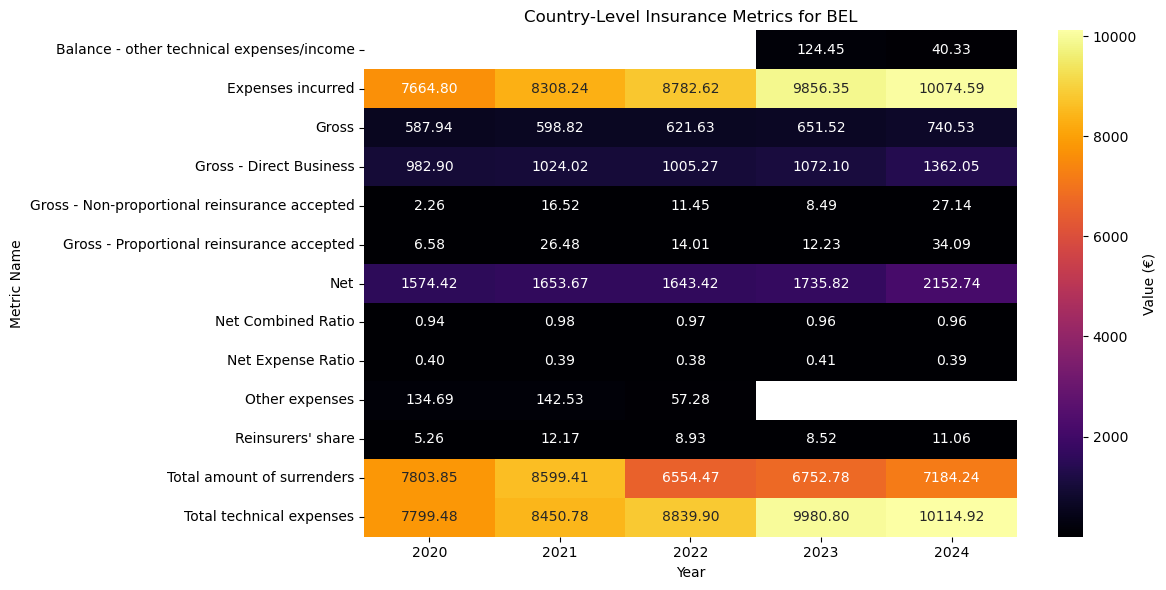

In [53]:
import seaborn as sns

# Visualise EIOPA metrics as heatmap
plt.figure(figsize=(12, 6))
pivot_table = df_insurance_metrics.pivot_table(
    index='metric_name',
    columns='year',
    values='value',
    aggfunc='sum'
)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="inferno", cbar_kws={'label': 'Value (€)'})
plt.title(f"Country-Level Insurance Metrics for {ISO_A3_COUNTRY_CODE}")
plt.ylabel("Metric Name")
plt.xlabel("Year")
plt.tight_layout()
plt.savefig(f"renderings/insurance_metrics_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

## Calculate Empirical Loss Ratios

Before estimating risk, we calculate **empirical loss ratios** from historical disaster events. These ratios are fundamental to risk assessment and insurance pricing.

### What is a Loss Ratio?

A **loss ratio** represents the proportion of economic exposure that was lost during past disaster events. It's calculated as:

$$
\text{Loss Ratio} = \frac{\text{Average Loss per Event}}{\text{Total Economic Exposure}} = \frac{\text{Total Historical Losses} / \text{Number of Events}}{\text{Regional Economic Exposure}}
$$

### Calculation Details

For each NUTS3 region and hazard type (Flood, Storm, Earthquake), we first aggregate all `EconomicExposureCell` values within the region, converting from USD to EUR. We then sum the `economic_loss_value` from all `LossEventImpact` nodes linked to disaster events in that region, and count the distinct `LossEvent` nodes that impacted it. Finally, we divide the average loss per event by the total exposure to obtain the loss ratio.

### Data Sources

Economic exposure comes from LitPop via `EconomicExposureCell` nodes (originally in USD, converted to EUR). Historical losses are sourced from EM-DAT via `LossEventImpact` nodes (in EUR), and event counts are derived from `LossEvent` nodes in the same dataset.

### How Loss Ratios Are Used

The computed loss ratios serve as **region-specific damage factors** in subsequent analyses. In the Location Risk Estimation section, we multiply exposure by vulnerability and loss ratio to estimate potential losses at any coordinate. The NUTS2 Risk Mapping section uses these regional loss ratios to generate risk maps instead of relying on generic assumptions. For Expected Annual Loss (EAL) calculations, we combine loss ratios with vulnerability scores to compute annualized risk. When a region has no historical data for a particular hazard type, we fall back to the country-level average; if that is also unavailable, a conservative default of 0.01% is applied.

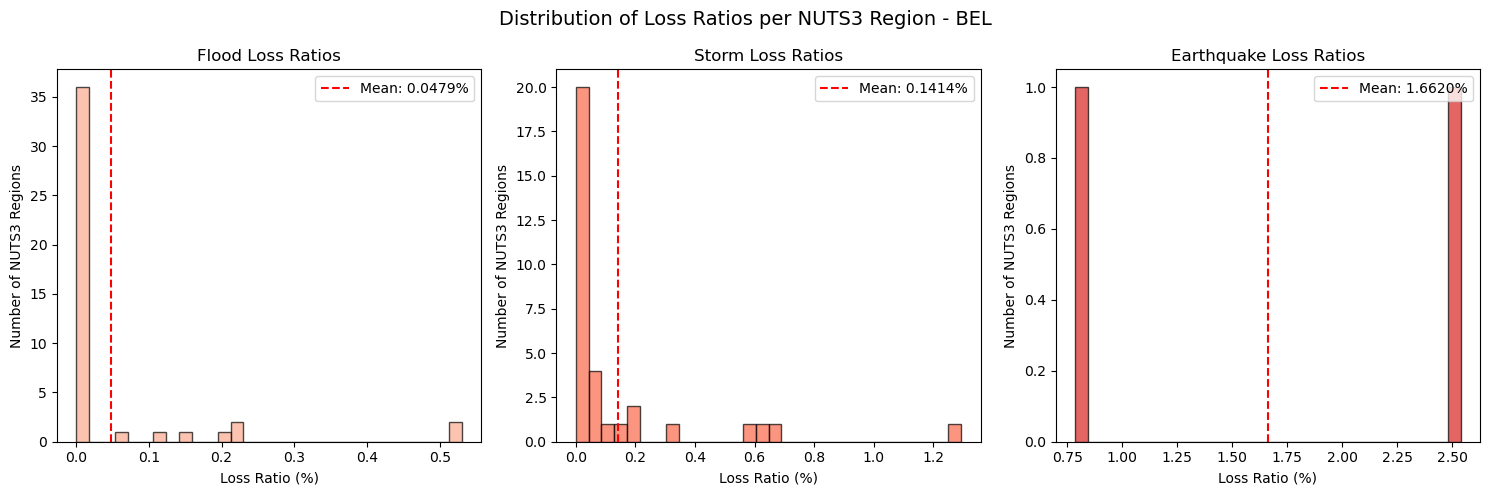

In [54]:
# Calculate empirical loss ratios per NUTS3 region
# Note: Exposure data is in USD, loss data is in EUR - convert exposure using USD_TO_EUR
query_loss_ratios = """
// Calculate loss ratios per NUTS3 region and hazard type
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF*]-(nuts3:Region {level: 3})

// Get total exposure for each NUTS3 region (convert USD to EUR)
OPTIONAL MATCH (nuts3)<-[:LOCATED_IN]-(cell:EconomicExposureCell)
WITH nuts3, sum(cell.value * $usd_to_eur) AS region_exposure

// Get losses for each NUTS3 region by hazard type (already in EUR)
OPTIONAL MATCH (nuts3)<-[:IMPACTED_REGION]-(event:LossEvent)
OPTIONAL MATCH (event)-[:HAS_IMPACT]->(impact:LossEventImpact {metric: 'economic_loss_value'})
WITH nuts3.nuts_code AS nuts_code,
     nuts3.name AS nuts_name,
     region_exposure,
     event.hazard_type AS hazard_type,
     sum(impact.value) AS total_loss,
     count(DISTINCT event) AS num_events
WHERE region_exposure > 0 AND hazard_type IS NOT NULL

// Calculate loss ratio: total_loss / (region_exposure * num_events) = avg loss per event / exposure
RETURN nuts_code,
       nuts_name,
       hazard_type,
       CASE WHEN num_events > 0 
            THEN total_loss / num_events / region_exposure 
            ELSE 0.0 
       END AS loss_ratio,
       total_loss,
       region_exposure,
       num_events
ORDER BY nuts_code, hazard_type
"""

# Using the analysis helper class
loss_ratio_records = analysis.run_query(query_loss_ratios, {
    'country_code': ISO_A3_COUNTRY_CODE, 
    'usd_to_eur': USD_TO_EUR
})

# Create a DataFrame for easier analysis
df_loss_ratios = pd.DataFrame(loss_ratio_records)

# Create nested dictionary: {nuts_code: {hazard_type: loss_ratio}}
loss_ratios = {}
for _, row in df_loss_ratios.iterrows():
    nuts_code = row['nuts_code']
    hazard_type = row['hazard_type']
    if nuts_code not in loss_ratios:
        loss_ratios[nuts_code] = {}
    loss_ratios[nuts_code][hazard_type] = row['loss_ratio']

# Default loss ratio if region/hazard type not found
DEFAULT_LOSS_RATIO = 0.0001  # 0.01% of exposure (conservative default)

# Calculate country-level average loss ratios by hazard type (for fallback)
avg_loss_ratios_by_hazard = df_loss_ratios.groupby('hazard_type')['loss_ratio'].mean().to_dict()

# Visualise loss ratio distribution by hazard type
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
hazard_types = df_loss_ratios['hazard_type'].unique()

for idx, hazard in enumerate(hazard_types):
    ax = axes[idx] if len(hazard_types) > 1 else axes
    data = df_loss_ratios[df_loss_ratios['hazard_type'] == hazard]['loss_ratio'] * 100
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color=plt.cm.Reds(0.3 + idx * 0.2))
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.4f}%')
    ax.set_title(f'{hazard} Loss Ratios')
    ax.set_xlabel('Loss Ratio (%)')
    ax.set_ylabel('Number of NUTS3 Regions')
    ax.legend()

plt.suptitle(f'Distribution of Loss Ratios per NUTS3 Region - {ISO_A3_COUNTRY_CODE}', fontsize=14)
plt.tight_layout()
plt.savefig(f"renderings/loss_ratios_nuts3_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

We can use the loss factors calculated above to estimate potential losses for any given location and hazard type, even if that specific location has not experienced a disaster event in the past. This is done by multiplying the economic exposure at that location by the vulnerability score for the hazard type and the loss ratio for the corresponding NUTS3 region. This allows us to provide risk estimates for locations that may not have direct historical loss data, leveraging regional patterns and relationships captured in the knowledge graph.

Let us produce a quick dashboard which presents data for a specific location and hazard type, showing the estimated impact compared to the economic exposure, as well as historical loss data for the region. This will help us understand how the different pieces of information in the graph can be combined to provide insights into risk at a granular level. The location of choice will be **Verviers**, a city in the Wallonia region of Belgium, which has been impacted by floods in the past and is therefore a good candidate for this analysis.

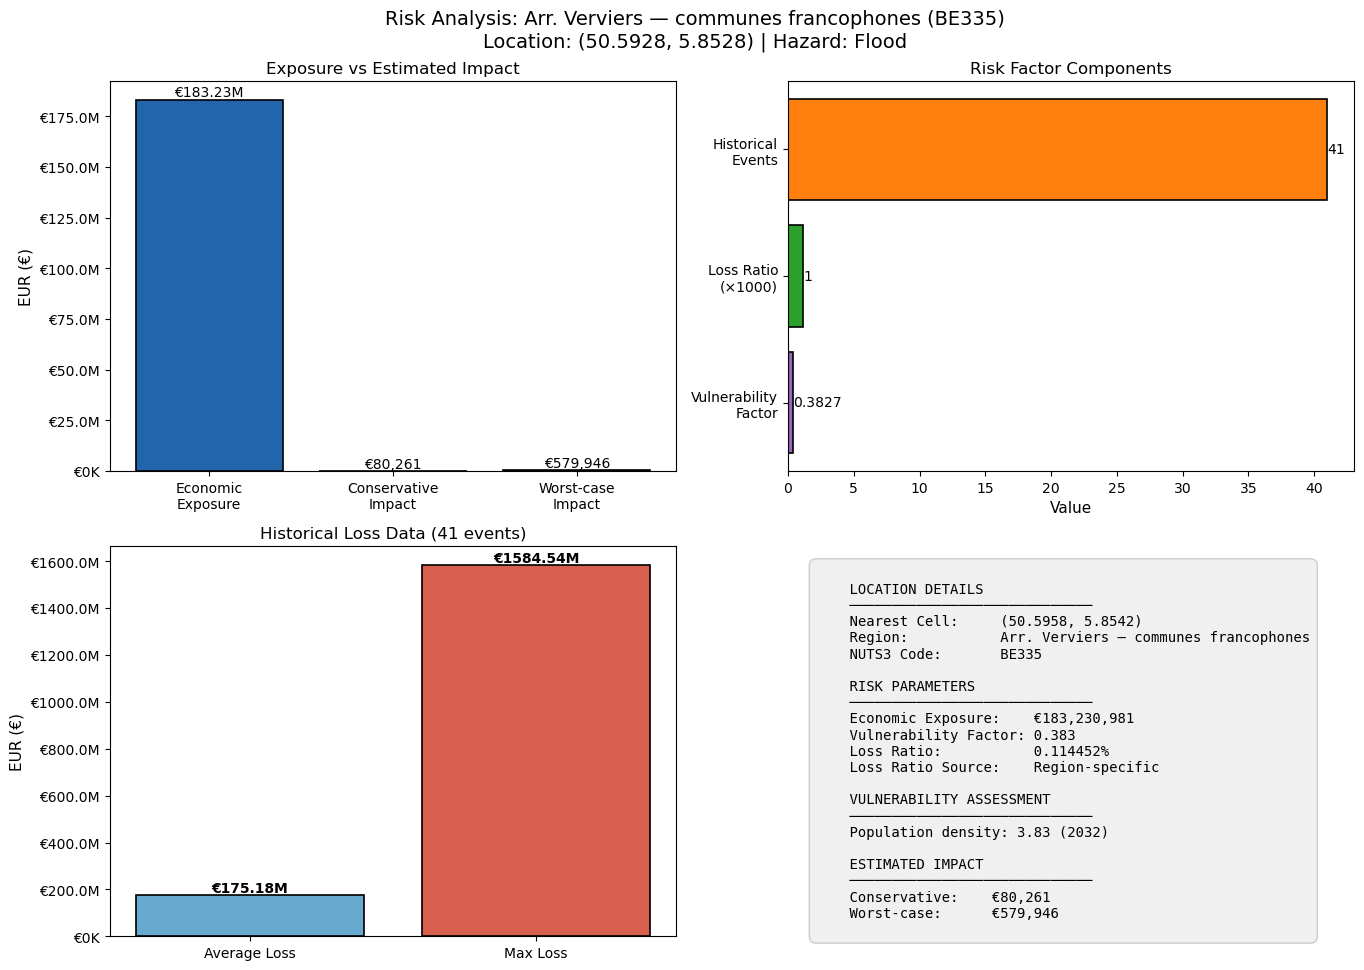

In [55]:
# Estimate economic impact for a location and hazard
# Updated to use region-specific loss ratios
query_location_risk = """
// Parameters: $lat, $lon, $hazard_type (e.g., "Flood"), $country_code
// Find the nearest EconomicExposureCell to the given coordinates within the specified country
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF*]-(region:Region)<-[:LOCATED_IN]-(cell:EconomicExposureCell)
WITH cell, 
     point.distance(
         point({latitude: $lat, longitude: $lon}), 
         point({latitude: cell.lat, longitude: cell.lon})
     ) AS distance
ORDER BY distance ASC
LIMIT 1

// Get the Region this cell is located in (NUTS3 level)
MATCH (cell)-[:LOCATED_IN]->(nuts3:Region {level: 3})

// Get historical loss data for this hazard type in the region hierarchy
// Search UP the hierarchy: NUTS3 -> NUTS2 -> NUTS1 (events may be recorded at any level)
OPTIONAL MATCH (nuts3)-[:PART_OF*0..2]->(parent:Region)<-[:IMPACTED_REGION]-(event:LossEvent {hazard_type: $hazard_type})
OPTIONAL MATCH (event)-[:HAS_IMPACT]->(impact:LossEventImpact {metric: 'economic_loss_value'})

// Collect loss values per event (not DISTINCT values - we want one value per event for proper avg/max)
WITH cell, nuts3, 
     collect({event_id: elementId(event), loss: impact.value}) AS event_losses
WITH cell, nuts3,
     [el IN event_losses WHERE el.loss IS NOT NULL | el.loss] AS direct_loss_values,
     size([el IN event_losses WHERE el.event_id IS NOT NULL]) AS direct_event_count

// If no events in direct hierarchy, expand to adjacent NUTS3 cells within the same NUTS2
OPTIONAL MATCH (nuts3)-[:PART_OF]->(nuts2:Region {level: 2})<-[:PART_OF]-(adjacent:Region {level: 3})
WHERE direct_event_count = 0
OPTIONAL MATCH (adjacent)<-[:IMPACTED_REGION]-(adj_event:LossEvent {hazard_type: $hazard_type})
OPTIONAL MATCH (adj_event)-[:HAS_IMPACT]->(adj_impact:LossEventImpact {metric: 'economic_loss_value'})

// Combine direct and adjacent data (collect all values, not DISTINCT)
WITH cell, nuts3,
     direct_loss_values,
     direct_event_count,
     [el IN collect({event_id: elementId(adj_event), loss: adj_impact.value}) WHERE el.loss IS NOT NULL | el.loss] AS adj_loss_values,
     size([el IN collect({event_id: elementId(adj_event), loss: adj_impact.value}) WHERE el.event_id IS NOT NULL]) AS adj_event_count
WITH cell, nuts3,
     direct_loss_values + adj_loss_values AS all_loss_values,
     direct_event_count + adj_event_count AS all_event_count
WITH cell, nuts3,
     CASE WHEN size(all_loss_values) > 0 THEN all_loss_values ELSE [] END AS loss_values,
     all_event_count AS event_count

// Calculate statistics
WITH cell, nuts3, event_count,
     CASE 
         WHEN size(loss_values) > 0 
         THEN reduce(sum = 0.0, val IN loss_values | sum + val) / size(loss_values)
         ELSE 0.0
     END AS avg_historical_loss,
     CASE 
         WHEN size(loss_values) > 0 
         THEN reduce(max = 0.0, val IN loss_values | CASE WHEN val > max THEN val ELSE max END)
         ELSE 0.0
     END AS max_historical_loss

// Get vulnerability score for the region
OPTIONAL MATCH (nuts3)-[vul_rel:HAS_VULNERABILITY]->(v:Vulnerability)
WHERE vul_rel.year IS NOT NULL
WITH cell, nuts3, event_count, avg_historical_loss, max_historical_loss, v, vul_rel
ORDER BY vul_rel.year DESC
WITH cell, nuts3, event_count, avg_historical_loss, max_historical_loss,
     collect({
         vulnerability: v.name, 
         score: vul_rel.score, 
         year: vul_rel.year
     }) AS vulnerabilities

// Return data (loss ratio applied in Python using region-specific values)
WITH cell, nuts3, event_count, avg_historical_loss, max_historical_loss, vulnerabilities,
     CASE 
         WHEN size(vulnerabilities) > 0 
         THEN vulnerabilities[0].score / 10.0  // Normalize to 0-1 range (score range: 0-10)
         ELSE 0.5  // Default medium vulnerability
     END AS vulnerability_factor

RETURN 
    cell.lat AS latitude,
    cell.lon AS longitude,
    cell.value * $usd_to_eur AS exposure_value,
    nuts3.nuts_code AS nuts3_code,
    nuts3.name AS region_name,
    event_count AS historical_events,
    avg_historical_loss,
    max_historical_loss,
    vulnerability_factor,
    vulnerabilities[0] AS latest_vulnerability
"""

# Helper function to get loss ratio for a region and hazard type
def get_loss_ratio(nuts3_code, hazard_type):
    """Get loss ratio for a specific NUTS3 region and hazard type.
    Falls back to country average if region-specific data not available."""
    if nuts3_code in loss_ratios and hazard_type in loss_ratios[nuts3_code]:
        return loss_ratios[nuts3_code][hazard_type]
    elif hazard_type in avg_loss_ratios_by_hazard:
        return avg_loss_ratios_by_hazard[hazard_type]
    return DEFAULT_LOSS_RATIO

# Example: Estimate flood impact near Verviers
hazard_type = 'Flood'

params_location = {
    # Lat/Lon for Verviers, Belgium (flood-prone area)
    'lat': 50.5928,
    'lon': 5.8528,
    'hazard_type': hazard_type,
    'country_code': ISO_A3_COUNTRY_CODE,
    'usd_to_eur': USD_TO_EUR
}

record = analysis.run_query_single(query_location_risk, params_location)

if record:
    # Get region-specific loss ratio
    nuts3_code = record['nuts3_code']
    region_loss_ratio = get_loss_ratio(nuts3_code, hazard_type)
    
    # Calculate estimated impacts using region-specific loss ratio
    exposure = record['exposure_value']
    vuln_factor = record['vulnerability_factor']
    estimated_conservative = exposure * vuln_factor * region_loss_ratio
    estimated_worst_case = exposure * (1 + vuln_factor) * region_loss_ratio * 2.0
    
    # Create visualization dashboard
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Risk Analysis: {record['region_name']} ({nuts3_code})\nLocation: ({params_location['lat']}, {params_location['lon']}) | Hazard: {hazard_type}", 
                 fontsize=14)
    
    # 1. Economic Exposure & Impact Comparison (Bar Chart)
    ax1 = axes[0, 0]
    categories = ['Economic\nExposure', 'Conservative\nImpact', 'Worst-case\nImpact']
    values = [exposure, estimated_conservative, estimated_worst_case]
    colors = ['#2166ac', '#f4a582', '#b2182b']
    bars = ax1.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)
    ax1.set_ylabel('EUR (€)', fontsize=11)
    ax1.set_title('Exposure vs Estimated Impact', fontsize=12)
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M' if x >= 1e6 else f'€{x/1e3:.0f}K'))
    for bar, val in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'€{val/1e6:.2f}M' if val >= 1e6 else f'€{val:,.0f}', 
                 ha='center', va='bottom', fontsize=10)
    
    # 2. Risk Factors Breakdown (Horizontal Bar)
    ax2 = axes[0, 1]
    factors = ['Vulnerability\nFactor', 'Loss Ratio\n(×1000)', 'Historical\nEvents']
    factor_values = [vuln_factor, region_loss_ratio * 1000, record['historical_events']]
    factor_colors = ['#9467bd', '#2ca02c', '#ff7f0e']
    y_pos = range(len(factors))
    bars2 = ax2.barh(y_pos, factor_values, color=factor_colors, edgecolor='black', linewidth=1.2)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(factors)
    ax2.set_xlabel('Value', fontsize=11)
    ax2.set_title('Risk Factor Components', fontsize=12)
    for bar, val in zip(bars2, factor_values):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{val:.4f}' if val < 1 else f'{val:.0f}', 
                 ha='left', va='center', fontsize=10)
    
    # 3. Historical Loss Data (if available)
    ax3 = axes[1, 0]
    hist_data = {
        'Average Loss': record['avg_historical_loss'],
        'Max Loss': record['max_historical_loss']
    }
    if record['avg_historical_loss'] > 0 or record['max_historical_loss'] > 0:
        bars3 = ax3.bar(hist_data.keys(), hist_data.values(), color=['#67a9cf', '#d6604d'], edgecolor='black', linewidth=1.2)
        ax3.set_ylabel('EUR (€)', fontsize=11)
        ax3.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M' if x >= 1e6 else f'€{x/1e3:.0f}K'))
        for bar, val in zip(bars3, hist_data.values()):
            if val > 0:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                         f'€{val/1e6:.2f}M' if val >= 1e6 else f'€{val:,.0f}', 
                         ha='center', va='bottom', fontsize=10, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'No historical loss data\navailable for this region', 
                 ha='center', va='center', fontsize=12, transform=ax3.transAxes)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
    ax3.set_title(f'Historical Loss Data ({record["historical_events"]} events)', fontsize=12)
    
    # 4. Summary Info Box
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Determine loss ratio source
    loss_ratio_source = "Region-specific" if (nuts3_code in loss_ratios and hazard_type in loss_ratios[nuts3_code]) else "Country average"
    
    # Vulnerability info
    vul_info = "N/A"
    if record['latest_vulnerability']:
        vul = record['latest_vulnerability']
        vul_info = f"{vul['vulnerability']}: {vul['score']:.2f} ({vul['year']})"
    
    summary_text = f"""
    LOCATION DETAILS
    ─────────────────────────────
    Nearest Cell:     ({record['latitude']:.4f}, {record['longitude']:.4f})
    Region:           {record['region_name']}
    NUTS3 Code:       {nuts3_code}
    
    RISK PARAMETERS
    ─────────────────────────────
    Economic Exposure:    €{exposure:,.0f}
    Vulnerability Factor: {vuln_factor:.3f}
    Loss Ratio:           {region_loss_ratio*100:.6f}%
    Loss Ratio Source:    {loss_ratio_source}
    
    VULNERABILITY ASSESSMENT
    ─────────────────────────────
    {vul_info}
    
    ESTIMATED IMPACT
    ─────────────────────────────
    Conservative:    €{estimated_conservative:,.0f}
    Worst-case:      €{estimated_worst_case:,.0f}
    """
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#f0f0f0', edgecolor='#cccccc'))
    
    plt.tight_layout()
    plt.savefig(f"renderings/location_risk_{nuts3_code}_{hazard_type}.png", bbox_inches='tight')
    plt.show()
else:
    print("No data found for the specified location")

### Regional Risk Mapping

Now let us use loss ratios to estimate risk across an entire NUTS2 region. Starting from the target location, we identify the containing NUTS2 region and then calculate risk metrics for all NUTS3 sub-regions within it.

For each NUTS3 region, we compute conservative and worst-case impact estimates using the formula:

$$
\text{Conservative Impact} = \text{Exposure} \times \text{Vulnerability Factor} \times \text{Loss Ratio}
$$

$$
\text{Worst-case Impact} = \text{Exposure} \times (1 + \text{Vulnerability Factor}) \times \text{Loss Ratio} \times 2
$$

The worst-case multiplier accounts for correlated losses, infrastructure damage amplification, and recovery costs that often exceed direct asset losses in major disaster events. This will include the NUTS3 region containing Verviers (`BE335`) as well as all surrounding NUTS3 regions within the same NUTS2. We can then visualize these risk estimates on a map, highlighting the relative risk levels across the region and identifying hotspots of potential vulnerability. This will provide valuable insights for insurers, policymakers, and stakeholders interested in understanding and mitigating disaster risk at a regional level.

In [56]:
# Query: Get all NUTS3 regions in the same NUTS2 and calculate impacts
query_nuts2_risk_map = """
// Find the NUTS2 region containing the target location
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF*]-(region:Region)<-[:LOCATED_IN]-(cell:EconomicExposureCell)
WITH cell, 
     point.distance(
         point({latitude: $lat, longitude: $lon}), 
         point({latitude: cell.lat, longitude: cell.lon})
     ) AS distance
ORDER BY distance ASC
LIMIT 1

MATCH (cell)-[:LOCATED_IN]->(nuts3:Region {level: 3})-[:PART_OF]->(nuts2:Region {level: 2})

// Get all NUTS3 regions in this NUTS2
MATCH (nuts2)<-[:PART_OF]-(all_nuts3:Region {level: 3})

// For each NUTS3, get exposure cells and calculate total exposure
MATCH (all_nuts3)<-[:LOCATED_IN]-(exposure_cell:EconomicExposureCell)
WITH all_nuts3, sum(exposure_cell.value * $usd_to_eur) AS total_exposure

// Get historical loss data for this NUTS3
OPTIONAL MATCH (all_nuts3)<-[:PART_OF*0..2]-(r:Region)<-[:IMPACTED_REGION]-(event:LossEvent {hazard_type: $hazard_type})
OPTIONAL MATCH (event)-[:HAS_IMPACT]->(impact:LossEventImpact {metric: 'economic_loss_value'})

WITH all_nuts3, total_exposure,
     collect(DISTINCT impact.value) AS direct_loss_values,
     count(DISTINCT event) AS direct_event_count

// If no events, try adjacent NUTS3 in same NUTS2
OPTIONAL MATCH (all_nuts3)-[:PART_OF]->(parent_nuts2:Region {level: 2})<-[:PART_OF]-(adjacent:Region {level: 3})
WHERE direct_event_count = 0
OPTIONAL MATCH (adjacent)<-[:IMPACTED_REGION]-(adj_event:LossEvent {hazard_type: $hazard_type})
OPTIONAL MATCH (adj_event)-[:HAS_IMPACT]->(adj_impact:LossEventImpact {metric: 'economic_loss_value'})

WITH all_nuts3, total_exposure,
     direct_loss_values,
     direct_event_count,
     collect(DISTINCT adj_impact.value) AS adj_loss_values,
     count(DISTINCT adj_event) AS adj_event_count

// Get vulnerability
OPTIONAL MATCH (all_nuts3)-[vul_rel:HAS_VULNERABILITY]->(v:Vulnerability)
WHERE vul_rel.year IS NOT NULL
WITH all_nuts3, total_exposure, direct_event_count + adj_event_count AS event_count, v, vul_rel
ORDER BY vul_rel.year DESC
WITH all_nuts3, total_exposure, event_count,
     CASE 
         WHEN collect(v.name)[0] IS NOT NULL 
         THEN collect(vul_rel.score)[0] / 10.0
         ELSE 0.5
     END AS vulnerability_factor

RETURN 
    all_nuts3.nuts_code AS nuts_code,
    all_nuts3.name AS region_name,
    total_exposure,
    event_count,
    vulnerability_factor,
    total_exposure * vulnerability_factor * $loss_ratio AS conservative_impact,
    total_exposure * (1 + vulnerability_factor) * $loss_ratio * 2.0 AS worst_case_impact
ORDER BY nuts_code
"""

# Execute query for the location
params_map = {
    'lat': params_location['lat'],
    'lon': params_location['lon'],
    'hazard_type': hazard_type,
    'country_code': ISO_A3_COUNTRY_CODE,
    'usd_to_eur': USD_TO_EUR,
    'loss_ratio': loss_ratios.get(hazard_type, DEFAULT_LOSS_RATIO)
}

nuts3_records = analysis.run_query(query_nuts2_risk_map, params_map)

df_nuts3_risks = pd.DataFrame(nuts3_records)
print(f"\nFound {len(df_nuts3_risks)} NUTS3 regions in the NUTS2 area")
df_nuts3_risks.head()


Found 5 NUTS3 regions in the NUTS2 area


nuts_code                                      region_name  total_exposure  \
0     BE331                                         Arr. Huy    8.430008e+09   
1     BE332                                       Arr. Liège    1.241636e+11   
2     BE334                                     Arr. Waremme    4.756306e+09   
3     BE335            Arr. Verviers — communes francophones    1.671134e+10   
4     BE336  Bezirk Verviers — Deutschsprachige Gemeinschaft    1.561148e+09   

   event_count  vulnerability_factor  conservative_impact  worst_case_impact  
0           10              0.380974        321161.388983       2.328324e+06  
1           10              0.067948        843666.517111       2.652004e+07  
2            8              0.406661        193420.399159       1.338102e+06  
3            9              0.382718        639572.887883       4.621413e+06  
4            8              0.302520         47227.843981       4.066853e+05

Fetching NUTS3 geometries...
Mapped 5 NUTS3 regions with geometries


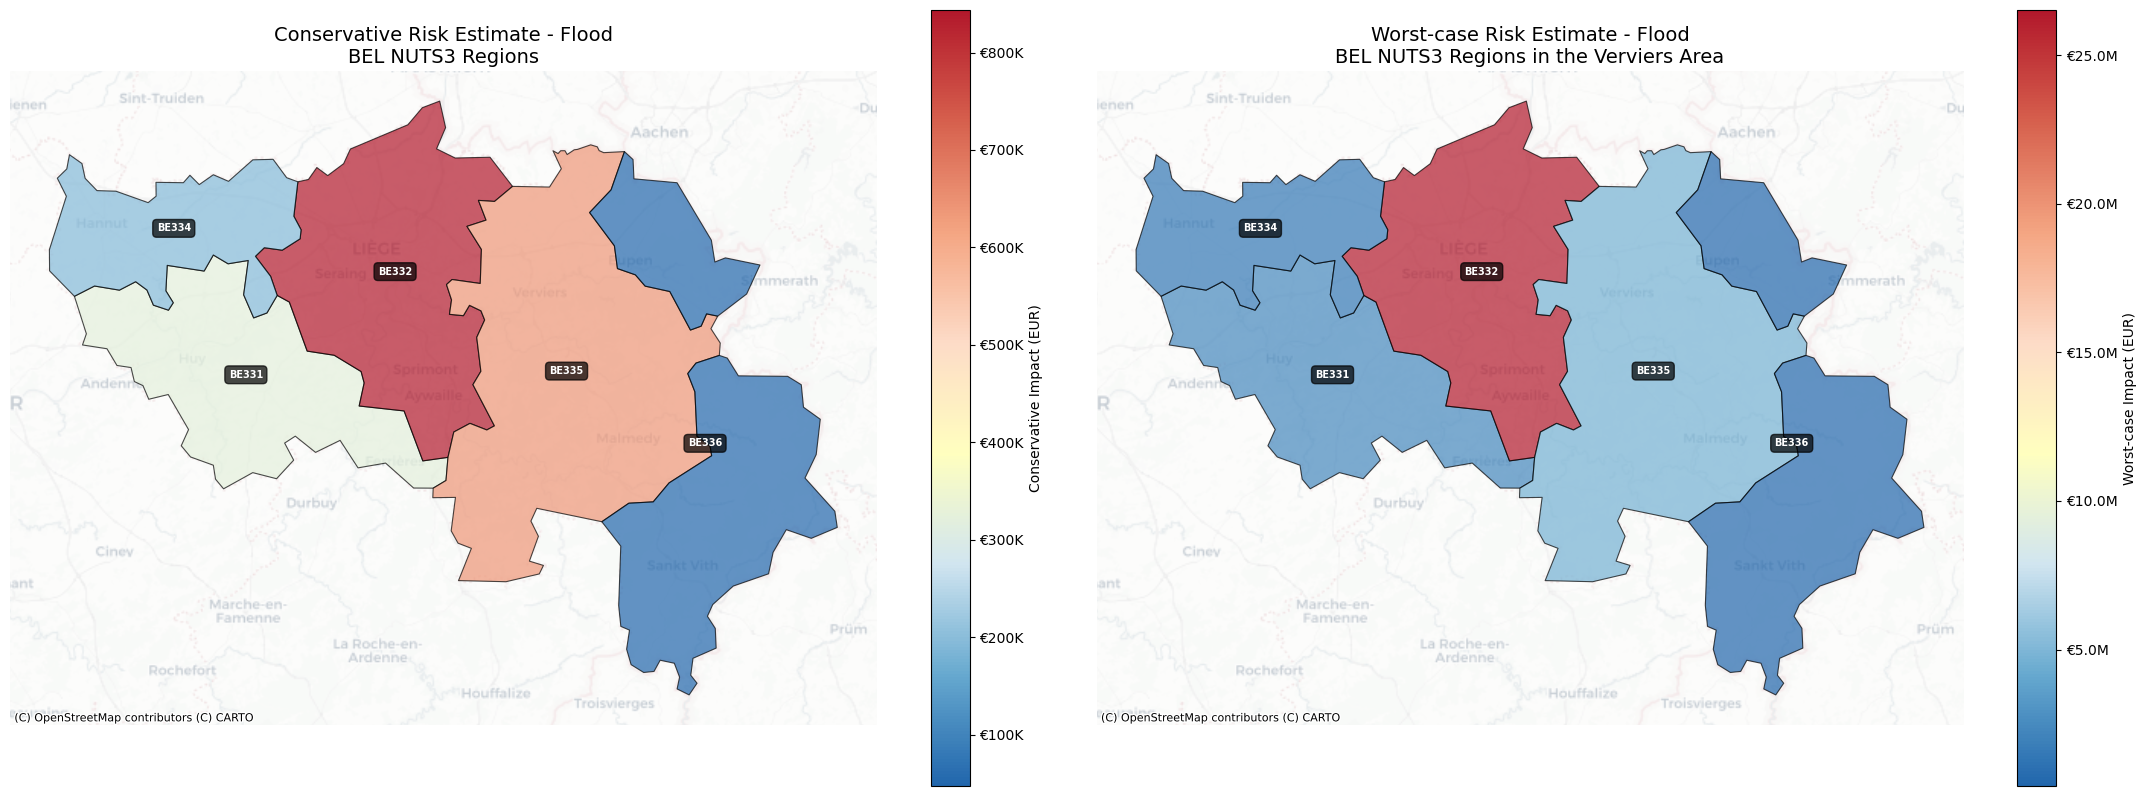

In [57]:
# Fetch NUTS3 geometries and create map visualization using the analysis helper

# Fetch NUTS3 geometries using the helper method
gdf_nuts3 = analysis.fetch_nuts3_geometries()

# Filter to only the NUTS3 regions we have data for
gdf_nuts3 = gdf_nuts3[gdf_nuts3['NUTS_ID'].isin(df_nuts3_risks['nuts_code'])]

# Merge with risk data
gdf_map = gdf_nuts3.merge(df_nuts3_risks, left_on='NUTS_ID', right_on='nuts_code', how='inner')

print(f"Mapped {len(gdf_map)} NUTS3 regions with geometries")

# Create two-column plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Get the standard risk colormap from the analysis helper
flood_cmap = analysis.get_risk_cmap()

# Plot 1: Conservative Impact using the helper method
analysis.plot_choropleth_map(
    gdf_map, 
    column='conservative_impact',
    title=f"Conservative Risk Estimate - {hazard_type}\n{ISO_A3_COUNTRY_CODE} NUTS3 Regions",
    ax=ax1,
    cmap=flood_cmap,
    legend_label="Conservative Impact (EUR)",
    alpha=0.7,
    edgecolor='black',
    linewidth=0.8,
    label_top_n=5
)

# Plot 2: Worst-case Impact using the helper method
analysis.plot_choropleth_map(
    gdf_map,
    column='worst_case_impact',
    title=f"Worst-case Risk Estimate - {hazard_type}\n{ISO_A3_COUNTRY_CODE} NUTS3 Regions in the Verviers Area",
    ax=ax2,
    cmap=flood_cmap,
    legend_label="Worst-case Impact (EUR)",
    alpha=0.7,
    edgecolor='black',
    linewidth=0.8,
    label_top_n=5
)

plt.tight_layout()
plt.savefig(f"renderings/nuts3_risk_map_{hazard_type}_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

## Risk-Adjusted Loss Potential Heatmap

This section creates a comprehensive risk assessment by combining three key data sources. Economic Exposure from LitPop provides the total value of assets in each NUTS3 region. Hazard and Vulnerability data from DRMKC supplies vulnerability scores and historical loss data used to estimate Expected Annual Loss (EAL). Insurance Coverage metrics from EIOPA indicate national insurance penetration and claims-to-premium ratios.

The resulting heatmap highlights **"Risk Hotspots"** — regions where Expected Annual Loss is high and insurance coverage is insufficient to absorb the economic shock from a disaster event.

### National Insurance Market Capacity

Before assessing regional risk, we first retrieve national-level insurance metrics from EIOPA to understand the overall market capacity. The key metric is the **Net Combined Ratio**, which measures insurance profitability as the ratio of (incurred losses + expenses) to earned premiums.

A combined ratio below 100% indicates the insurance market is profitable and has capacity to absorb additional losses. A ratio at or above 100% signals a stressed market where insurers are paying out as much or more than they collect in premiums. This national baseline will later be used to generate synthetic regional combined ratios, allowing us to identify areas where insurance capacity may be insufficient relative to the expected losses.

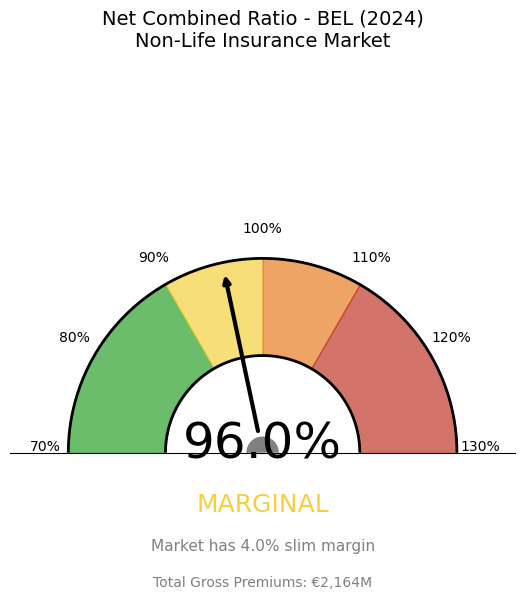

In [58]:
# Get national insurance metrics (penetration and claims-to-premium ratio)
query_national_insurance = """
MATCH (c:Country {iso_a3: $country_code})-[r:REPORTED_FINANCIALS]->(m:InsuranceMetric)
WHERE r.year = $year
WITH m.name AS metric_name, 
     m.business_type AS business_type,
     r.value AS value
RETURN metric_name, business_type, value
"""

# Get the most recent year's data
insurance_records = analysis.run_query(query_national_insurance, {
    'country_code': ISO_A3_COUNTRY_CODE,
    'year': 2024
})

df_insurance_metrics = pd.DataFrame(insurance_records)

# Calculate total gross premiums (market size indicator)
total_gross_premiums = df_insurance_metrics[
    df_insurance_metrics['metric_name'].str.contains('Gross', case=False, na=False)
]['value'].sum()

# Get Net Combined Ratio for Non-Life business
# Combined Ratio = (Incurred Losses + Expenses) / Earned Premiums
# Ratio > 1.0 means unprofitable underwriting (paying out more than collecting)
# Ratio < 1.0 means profitable underwriting
net_combined_ratio_records = df_insurance_metrics[
    (df_insurance_metrics['metric_name'] == 'Net Combined Ratio') &
    (df_insurance_metrics['business_type'] == 'Non-Life')
]

if not net_combined_ratio_records.empty:
    net_combined_ratio = net_combined_ratio_records['value'].iloc[0]
else:
    # If not available, estimate from expenses and net premiums
    net_premiums = df_insurance_metrics[
        df_insurance_metrics['metric_name'] == 'Net'
    ]['value'].sum()
    total_expenses = df_insurance_metrics[
        df_insurance_metrics['metric_name'] == 'Expenses incurred'
    ]['value'].sum()
    net_combined_ratio = total_expenses / net_premiums if net_premiums > 0 else 1.0

# Create gauge visualization for Net Combined Ratio
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': 'polar'})

# Gauge parameters
min_val, max_val = 0.7, 1.3  # 70% to 130%
range_val = max_val - min_val

# Convert ratio to angle (gauge spans from 180° to 0°, i.e., left to right)
ratio_normalized = (net_combined_ratio - min_val) / range_val
ratio_normalized = np.clip(ratio_normalized, 0, 1)  # Clamp to valid range
needle_angle = np.pi * (1 - ratio_normalized)  # 180° to 0°

# Draw gauge background segments
# Green zone: 70-90% (profitable)
# Yellow zone: 90-100% (marginal)
# Orange zone: 100-110% (stressed)
# Red zone: 110-130% (unprofitable)
zones = [
    (0.7, 0.9, '#2ca02c', 'Profitable'),
    (0.9, 1.0, '#f4d03f', 'Marginal'),
    (1.0, 1.1, '#e67e22', 'Stressed'),
    (1.1, 1.3, '#c0392b', 'Unprofitable')
]

for zone_min, zone_max, color, label in zones:
    start_angle = np.pi * (1 - (zone_min - min_val) / range_val)
    end_angle = np.pi * (1 - (zone_max - min_val) / range_val)
    theta = np.linspace(start_angle, end_angle, 50)
    ax.fill_between(theta, 0.5, 1.0, color=color, alpha=0.7)

# Draw gauge border
theta_border = np.linspace(0, np.pi, 100)
ax.plot(theta_border, [1.0]*100, color='black', linewidth=2)
ax.plot(theta_border, [0.5]*100, color='black', linewidth=2)

# Draw needle
ax.annotate('', xy=(needle_angle, 0.95), xytext=(needle_angle, 0.1),
            arrowprops=dict(arrowstyle='->', color='black', lw=3))

# Add center circle
circle = plt.Circle((0, 0), 0.08, transform=ax.transData._b, color='gray', zorder=10)
ax.add_artist(circle)

# Add tick labels
tick_values = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
for val in tick_values:
    angle = np.pi * (1 - (val - min_val) / range_val)
    ax.text(angle, 1.12, f'{val*100:.0f}%', ha='center', va='bottom', fontsize=10)

# Configure polar plot to show only top half
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim(0, 1.3)
ax.set_yticks([])
ax.set_xticks([])
ax.spines['polar'].set_visible(False)

# Add title and value display
ax.set_title(f'Net Combined Ratio - {ISO_A3_COUNTRY_CODE} (2024)\nNon-Life Insurance Market', 
             fontsize=14, pad=20)

# Add current value text below gauge
fig.text(0.5, 0.25, f'{net_combined_ratio*100:.1f}%', ha='center', va='center', 
         fontsize=36, color='black')

# Determine status and color
if net_combined_ratio < 0.9:
    status = "PROFITABLE"
    status_color = '#2ca02c'
    capacity_text = f"Market has {(1-net_combined_ratio)*100:.1f}% capacity margin"
elif net_combined_ratio < 1.0:
    status = "MARGINAL"
    status_color = '#f4d03f'
    capacity_text = f"Market has {(1-net_combined_ratio)*100:.1f}% slim margin"
elif net_combined_ratio < 1.1:
    status = "STRESSED"
    status_color = '#e67e22'
    capacity_text = f"Market losing {(net_combined_ratio-1)*100:.1f}% on underwriting"
else:
    status = "UNPROFITABLE"
    status_color = '#c0392b'
    capacity_text = f"Market losing {(net_combined_ratio-1)*100:.1f}% on underwriting"

fig.text(0.5, 0.15, status, ha='center', va='center', fontsize=18, color=status_color)
fig.text(0.5, 0.08, capacity_text, ha='center', va='center', fontsize=11, color='gray')

# Add gross premiums info
fig.text(0.5, 0.02, f'Total Gross Premiums: €{total_gross_premiums:,.0f}M', 
         ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig(f"renderings/insurance_gauge_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

### Expected Annual Loss (EAL) by Region

Now that we know the nation-wide margin for absorbing losses, let us calculate **Expected Annual Loss (EAL)** for each NUTS3 region by combining economic exposure with vulnerability and historical loss data.

For regions with historical loss events:

$$
\text{EAL} = \text{Average Loss per Event} \times \text{Vulnerability Factor}
$$

For regions without historical data, we apply a conservative default:

$$
\text{EAL} = \text{Total Exposure} \times \text{Vulnerability Factor} \times 0.02
$$

This approach ensures all regions receive a risk estimate while prioritizing empirical data where available.

In [59]:
# Calculate Expected Annual Loss (EAL) for each NUTS3 region
query_nuts3_eal = """
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF*]-(nuts3:Region {level: 3})

// Get total economic exposure for this NUTS3
MATCH (nuts3)<-[:LOCATED_IN]-(cell:EconomicExposureCell)
WITH nuts3, sum(cell.value * $usd_to_eur) AS total_exposure

// Get vulnerability score
OPTIONAL MATCH (nuts3)-[vul_rel:HAS_VULNERABILITY]->(v:Vulnerability)
WHERE vul_rel.year IS NOT NULL
WITH nuts3, total_exposure, v, vul_rel
ORDER BY vul_rel.year DESC
WITH nuts3, total_exposure,
     CASE 
         WHEN collect(v.name)[0] IS NOT NULL 
         THEN collect(vul_rel.score)[0] / 10.0
         ELSE 0.5
     END AS vulnerability_factor,
     collect(v.name)[0] AS vulnerability_name

// Get historical loss events for all hazard types
OPTIONAL MATCH (nuts3)<-[:IMPACTED_REGION]-(event:LossEvent)
OPTIONAL MATCH (event)-[:HAS_IMPACT]->(impact:LossEventImpact {metric: 'economic_loss_value'})

WITH nuts3, total_exposure, vulnerability_factor, vulnerability_name,
     collect(DISTINCT event.hazard_type) AS hazard_types,
     count(DISTINCT event) AS event_count,
     CASE 
         WHEN count(DISTINCT event) > 0
         THEN sum(impact.value) / count(DISTINCT event)
         ELSE 0.0
     END AS avg_loss_per_event

// Calculate Expected Annual Loss (EAL)
// EAL = Total Exposure × Vulnerability Factor × Average Loss Rate
// We'll use a combination of historical losses and vulnerability scores
WITH nuts3, total_exposure, vulnerability_factor, vulnerability_name,
     event_count, avg_loss_per_event, hazard_types,
     CASE
         WHEN event_count > 0 THEN avg_loss_per_event * vulnerability_factor
         ELSE total_exposure * vulnerability_factor * 0.02  // Default 2% annual risk
     END AS expected_annual_loss

RETURN 
    nuts3.nuts_code AS nuts_code,
    nuts3.name AS region_name,
    total_exposure,
    vulnerability_factor,
    vulnerability_name,
    event_count,
    avg_loss_per_event,
    hazard_types,
    expected_annual_loss
ORDER BY nuts_code
"""

eal_records = analysis.run_query(query_nuts3_eal, {
    'country_code': ISO_A3_COUNTRY_CODE,
    'usd_to_eur': USD_TO_EUR
})

df_eal = pd.DataFrame(eal_records)

print(f"\nCalculated EAL for {len(df_eal)} NUTS3 regions")
print(f"Total Economic Exposure: €{df_eal['total_exposure'].sum():,.0f}")
print(f"Total Expected Annual Loss: €{df_eal['expected_annual_loss'].sum():,.0f}")
df_eal.head(10)


Calculated EAL for 44 NUTS3 regions
Total Economic Exposure: €1,741,103,878,632
Total Expected Annual Loss: €251,566,208


nuts_code                                        region_name  \
0     BE100  Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad   
1     BE211                                     Arr. Antwerpen   
2     BE212                                      Arr. Mechelen   
3     BE213                                      Arr. Turnhout   
4     BE223                                      Arr. Tongeren   
5     BE224                                       Arr. Hasselt   
6     BE225                                       Arr. Maaseik   
7     BE231                                         Arr. Aalst   
8     BE232                                   Arr. Dendermonde   
9     BE233                                         Arr. Eeklo   

   total_exposure  vulnerability_factor  vulnerability_name  event_count  \
0    3.230503e+11              0.880479  Population density            8   
1    2.038440e+11              0.036667              Access           10   
2    6.643470e+10              0.559539  Population density            6   
3    3.522289e+10              0.469775  Population density            8   
4    1.745355e+10              0.462507  Population density            8   
5    5.251565e+10              0.562218       Net migration           12   
6    1.541788e+10              0.529653       Net migration            9   
7    4.133490e+10              0.545833  Population density            6   
8    3.069000e+10              0.536700  Population density            6   
9    6.644975e+09              0.438060  Population density            6   

   avg_loss_per_event         hazard_types  expected_annual_loss  
0        5.459538e+07       [Flood, Storm]          4.807009e+07  
1        2.654517e+06       [Flood, Storm]          9.733319e+04  
2        4.513365e+06       [Flood, Storm]          2.525404e+06  
3        1.112623e+06       [Flood, Storm]          5.226825e+05  
4        3.970808e+07              [Flood]          1.836527e+07  
5        7.121158e+06       [Flood, Storm]          4.003643e+06  
6        4.454429e+07  [Earthquake, Flood]          2.359302e+07  
7        7.619333e+05       [Flood, Storm]          4.158883e+05  
8        2.157747e+06       [Flood, Storm]          1.158063e+06  
9        9.471856e+05       [Flood, Storm]          4.149241e+05

### Synthetic Regional Combined Ratios

Since insurance combined ratios are typically reported at the national level, we generate **synthetic regional combined ratios** for each NUTS3 region to enable more granular risk assessment. The regional ratio is computed as:

$$
\text{Regional CR} = \text{National CR} + \text{Exposure Adjustment} + \text{Vulnerability Adjustment} + \text{Random Jitter}
$$

The exposure adjustment (±5% maximum) reflects that high-value regions may have different loss characteristics. The vulnerability adjustment incorporates regional vulnerability scores, with higher vulnerability leading to higher expected claims. Random jitter (±3% standard deviation) adds realistic variation to reflect local market conditions. All values are constrained between 70% and 130% to ensure realistic insurance market conditions.

These synthetic ratios are then used to calculate the **Risk-Adjusted Loss Potential (RALP)**, which amplifies risk in regions where the insurance market is already stressed and has limited capacity to absorb additional losses.

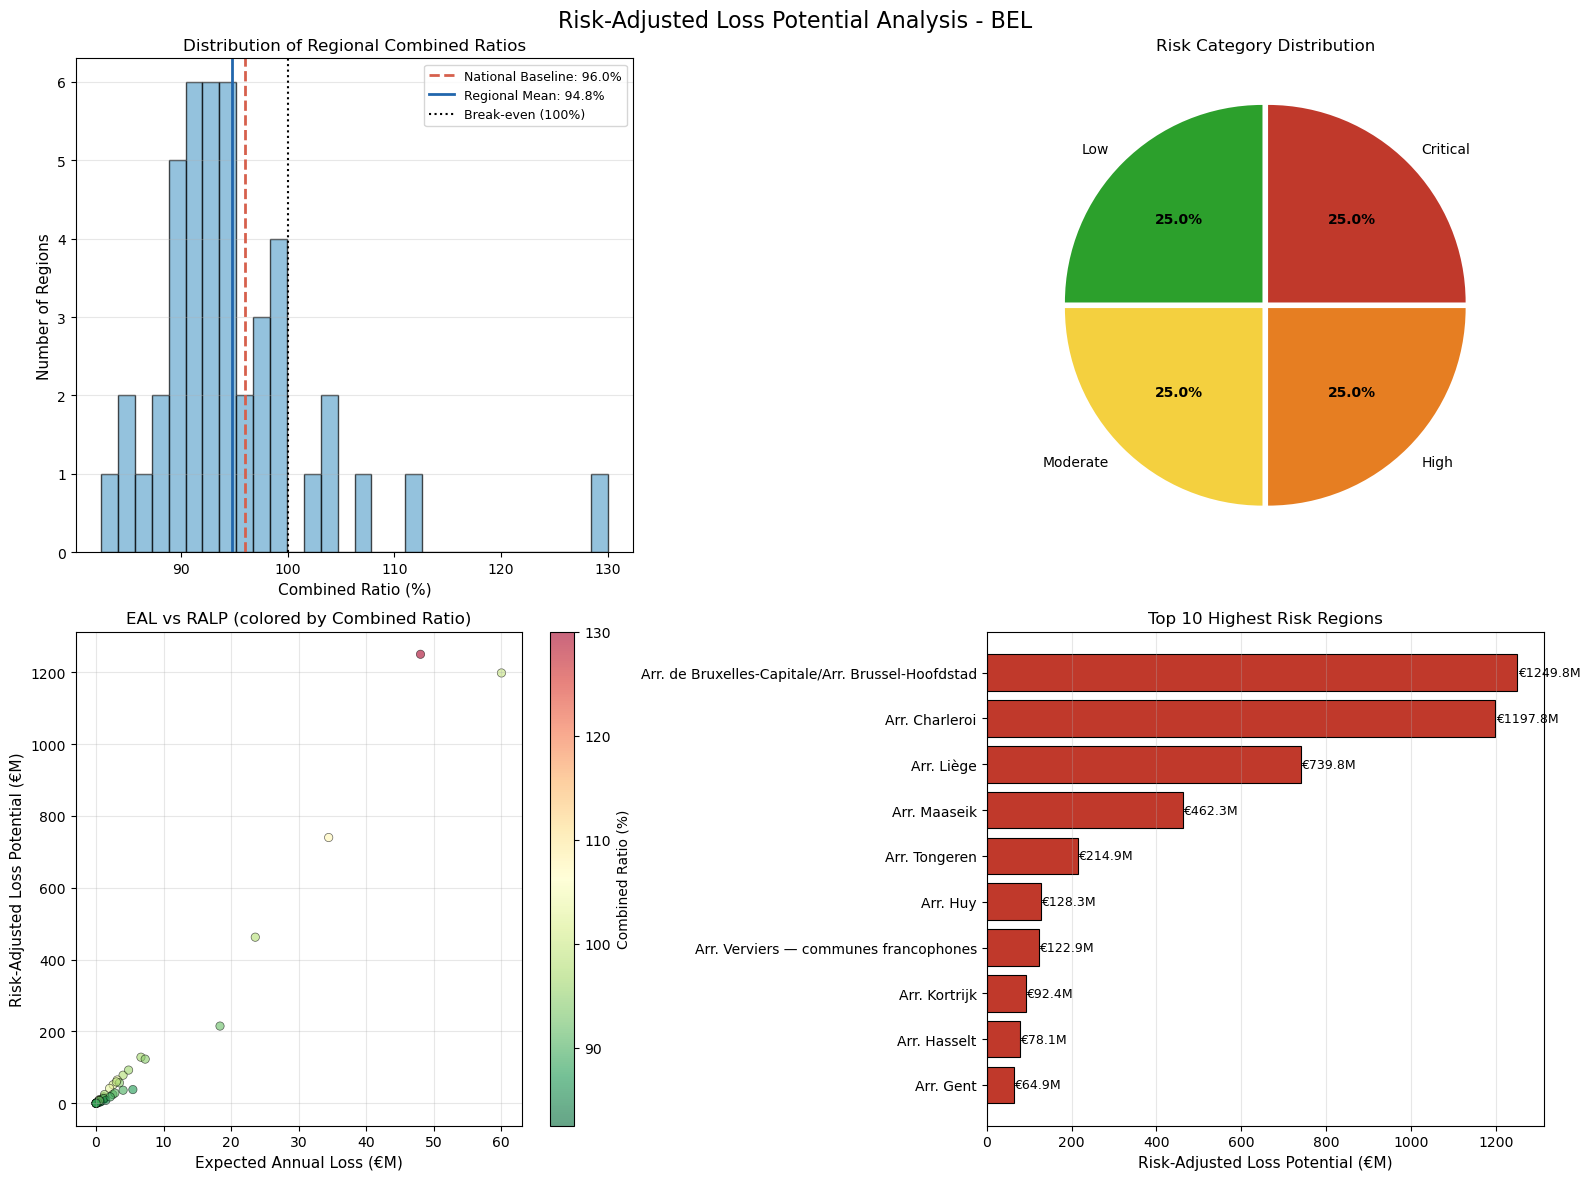

In [60]:
# Calculate Risk-Adjusted Loss Potential (RALP)
# RALP combines EAL with insurance coverage gaps
# Higher values indicate regions where disasters would cause economic shocks 
# that insurance cannot absorb

# Insurance Gap Factor based on Combined Ratio:
# Combined Ratio close to 1.0 (100%) means insurance market is at capacity
# Combined Ratio > 1.0 means market is stressed (unprofitable)
# Combined Ratio < 1.0 means market has capacity to absorb additional losses

# Create synthetic regional combined ratios based on exposure and national baseline
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Calculate exposure-based weights (higher exposure regions may have different risk profiles)
df_eal['exposure_weight'] = df_eal['total_exposure'] / df_eal['total_exposure'].mean()

# Calculate vulnerability-based adjustment (higher vulnerability = potentially higher claims)
df_eal['vulnerability_adjustment'] = (df_eal['vulnerability_factor'] - 0.5) * 0.1

# Generate synthetic regional combined ratios
# Base: national ratio, adjusted by exposure weight and vulnerability, with random jitter
df_eal['regional_combined_ratio'] = (
    net_combined_ratio + 
    (df_eal['exposure_weight'] - 1.0) * 0.05 +  # Exposure-based deviation (±5%)
    df_eal['vulnerability_adjustment'] +         # Vulnerability adjustment
    np.random.normal(0, 0.03, len(df_eal))      # Random jitter (±3% std)
)

# Constrain to reasonable bounds (70% to 130%)
df_eal['regional_combined_ratio'] = df_eal['regional_combined_ratio'].clip(0.70, 1.30)

# Calculate regional insurance stress factors and capacities
df_eal['insurance_stress_factor'] = df_eal['regional_combined_ratio']
df_eal['insurance_capacity'] = np.maximum(0.05, 1.0 - df_eal['regional_combined_ratio'])

# Risk-Adjusted Loss Potential = EAL × Regional Combined Ratio / Regional Capacity
# This amplifies risk in regions where insurance market is already at/near capacity
df_eal['risk_adjusted_loss_potential'] = (
    df_eal['expected_annual_loss'] * 
    df_eal['insurance_stress_factor'] / 
    df_eal['insurance_capacity']
)

# Calculate EAL as percentage of exposure for normalization
df_eal['eal_percentage'] = (df_eal['expected_annual_loss'] / df_eal['total_exposure']) * 100

# Create risk categories - handle case where quantiles may be duplicate
bins = [0, 
        df_eal['risk_adjusted_loss_potential'].quantile(0.25),
        df_eal['risk_adjusted_loss_potential'].quantile(0.5),
        df_eal['risk_adjusted_loss_potential'].quantile(0.75),
        df_eal['risk_adjusted_loss_potential'].max()]

# Remove duplicate bins
unique_bins = sorted(list(set(bins)))

# Create labels based on number of unique bins
if len(unique_bins) == 5:
    risk_labels = ['Low', 'Moderate', 'High', 'Critical']
elif len(unique_bins) == 4:
    risk_labels = ['Low', 'Moderate', 'High']
elif len(unique_bins) == 3:
    risk_labels = ['Low', 'High']
elif len(unique_bins) == 2:
    risk_labels = ['Medium']
else:
    risk_labels = None

if risk_labels:
    df_eal['risk_category'] = pd.cut(
        df_eal['risk_adjusted_loss_potential'],
        bins=unique_bins,
        labels=risk_labels,
        include_lowest=True
    )
else:
    df_eal['risk_category'] = 'Medium'  # All values are the same

# Create visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Risk-Adjusted Loss Potential Analysis - {ISO_A3_COUNTRY_CODE}', fontsize=16)

# 1. Distribution of Regional Combined Ratios with national baseline
ax1 = axes[0, 0]
ax1.hist(df_eal['regional_combined_ratio'] * 100, bins=30, color='#67a9cf', edgecolor='black', alpha=0.7)
ax1.axvline(net_combined_ratio * 100, color='#d6604d', linestyle='--', linewidth=2, 
            label=f'National Baseline: {net_combined_ratio*100:.1f}%')
ax1.axvline(df_eal['regional_combined_ratio'].mean() * 100, color='#2166ac', linestyle='-', linewidth=2,
            label=f'Regional Mean: {df_eal["regional_combined_ratio"].mean()*100:.1f}%')
ax1.axvline(100, color='black', linestyle=':', linewidth=1.5, label='Break-even (100%)')
ax1.set_xlabel('Combined Ratio (%)', fontsize=11)
ax1.set_ylabel('Number of Regions', fontsize=11)
ax1.set_title('Distribution of Regional Combined Ratios', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2. Risk Category Distribution (Pie Chart)
ax2 = axes[0, 1]
risk_counts = df_eal['risk_category'].value_counts().sort_index()
colors_pie = {'Low': '#2ca02c', 'Moderate': '#f4d03f', 'High': '#e67e22', 'Critical': '#c0392b', 'Medium': '#7f8c8d'}
pie_colors = [colors_pie.get(cat, '#7f8c8d') for cat in risk_counts.index]
wedges, texts, autotexts = ax2.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
                                    colors=pie_colors, startangle=90, explode=[0.02]*len(risk_counts))
ax2.set_title('Risk Category Distribution', fontsize=12)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# 3. EAL vs RALP Scatter Plot
ax3 = axes[1, 0]
scatter = ax3.scatter(df_eal['expected_annual_loss'] / 1e6, 
                      df_eal['risk_adjusted_loss_potential'] / 1e6,
                      c=df_eal['regional_combined_ratio'] * 100,
                      cmap='RdYlGn_r', alpha=0.6, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Combined Ratio (%)', fontsize=10)
ax3.set_xlabel('Expected Annual Loss (€M)', fontsize=11)
ax3.set_ylabel('Risk-Adjusted Loss Potential (€M)', fontsize=11)
ax3.set_title('EAL vs RALP (colored by Combined Ratio)', fontsize=12)
ax3.grid(alpha=0.3)

# 4. Top 10 Highest Risk Regions (Horizontal Bar)
ax4 = axes[1, 1]
top_10 = df_eal.nlargest(10, 'risk_adjusted_loss_potential').sort_values('risk_adjusted_loss_potential')
bar_colors = [colors_pie.get(cat, '#7f8c8d') for cat in top_10['risk_category']]
bars = ax4.barh(top_10['region_name'], top_10['risk_adjusted_loss_potential'] / 1e6, 
                color=bar_colors, edgecolor='black', linewidth=0.8)
ax4.set_xlabel('Risk-Adjusted Loss Potential (€M)', fontsize=11)
ax4.set_title('Top 10 Highest Risk Regions', fontsize=12)
ax4.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, top_10['risk_adjusted_loss_potential'] / 1e6):
    ax4.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'€{val:.1f}M', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"renderings/ralp_analysis_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

Now that we have the Risk-Adjusted Loss Potential calculated for each region, we can visualize the results in a heatmap. This will allow us to easily identify which regions are at higher risk due to a combination of high expected losses and limited insurance coverage.

Fetching NUTS3 geometries...
Mapped 44 NUTS3 regions with risk data


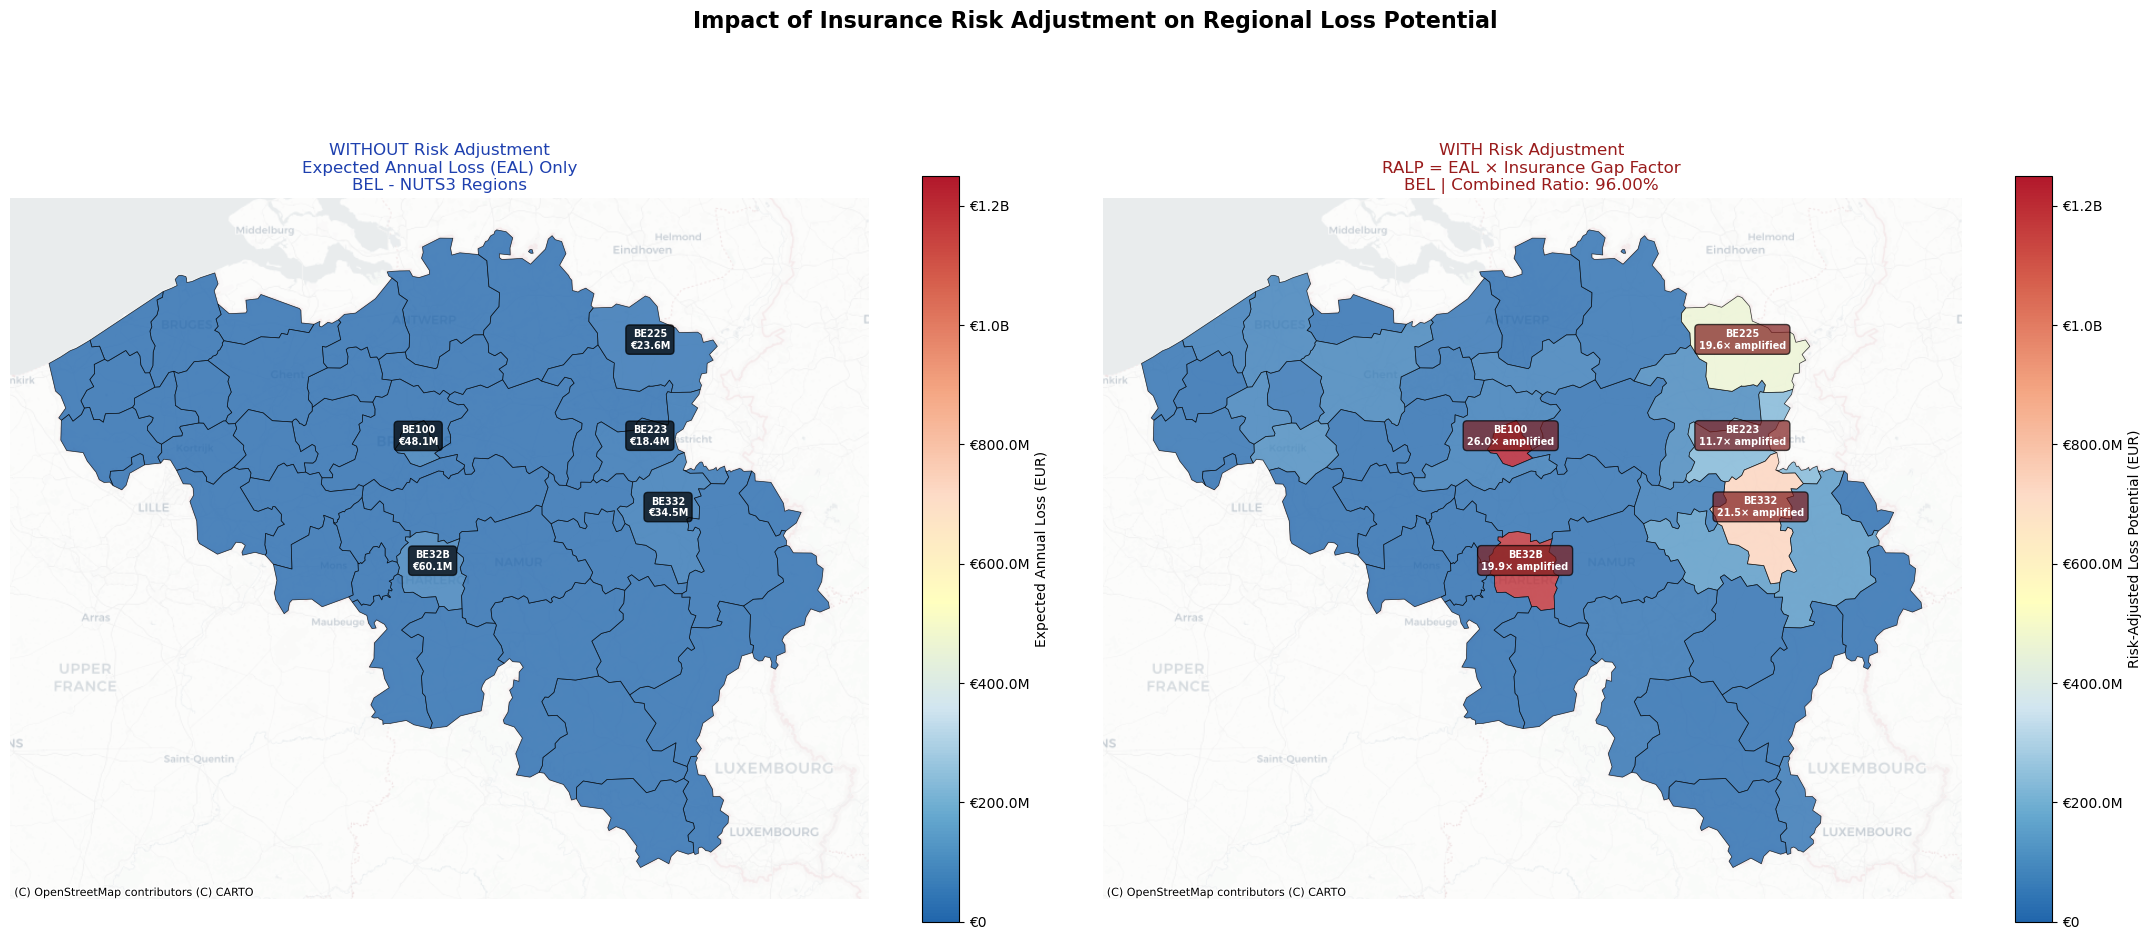

In [61]:
# Create Comparative Heatmaps: Without vs With Risk Adjustment

# Fetch NUTS3 geometries and merge with risk data
gdf_nuts3_full = analysis.fetch_nuts3_geometries()
gdf_nuts3_country = gdf_nuts3_full[gdf_nuts3_full['CNTR_CODE'] == ISO_A3_COUNTRY_CODE[:2]]
gdf_risk = gdf_nuts3_country.merge(df_eal, left_on='NUTS_ID', right_on='nuts_code', how='inner')

print(f"Mapped {len(gdf_risk)} NUTS3 regions with risk data")

# Normalize both datasets to same scale for fair comparison
from matplotlib.colors import Normalize
max_value = gdf_risk['risk_adjusted_loss_potential'].max()
norm = Normalize(vmin=0, vmax=max_value)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Plot 1: WITHOUT Risk Adjustment (Raw Expected Annual Loss)
analysis.plot_choropleth_map(
    gdf=gdf_risk,
    column='expected_annual_loss',
    title=f"WITHOUT Risk Adjustment\nExpected Annual Loss (EAL) Only\n{ISO_A3_COUNTRY_CODE} - NUTS3 Regions",
    ax=ax1,
    legend_label="Expected Annual Loss (EUR)",
    alpha=0.8,
    norm=norm,
    label_top_n=5,
    label_func=lambda row: f"{row['NUTS_ID']}\n€{row['expected_annual_loss']/1e6:.1f}M"
)
ax1.set_title(ax1.get_title(), color='#1e40af')

# Plot 2: WITH Risk Adjustment (Insurance Gap Applied)
analysis.plot_choropleth_map(
    gdf=gdf_risk,
    column='risk_adjusted_loss_potential',
    title=f"WITH Risk Adjustment\nRALP = EAL × Insurance Gap Factor\n{ISO_A3_COUNTRY_CODE} | Combined Ratio: {net_combined_ratio:.2%}",
    ax=ax2,
    legend_label="Risk-Adjusted Loss Potential (EUR)",
    alpha=0.8,
    norm=norm,
    label_top_n=5,
    label_func=lambda row: f"{row['NUTS_ID']}\n{row['risk_adjusted_loss_potential'] / row['expected_annual_loss']:.1f}× amplified" if row['expected_annual_loss'] > 0 else row['NUTS_ID'],
    label_bbox_color='#7f1d1d'
)
ax2.set_title(ax2.get_title(), color='#991b1b')

# Add overall title explaining the comparison
fig.suptitle(
    "Impact of Insurance Risk Adjustment on Regional Loss Potential",
    fontsize=16, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.savefig(f"renderings/ralp_heatmap_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

## Sub-National Protection Gap

The protection gap represents the difference between the insurance coverage a region needs to adequately protect against disaster risks and the coverage it actually has. This analysis identifies regions where insurance markets are failing to provide sufficient protection relative to the underlying hazard and economic exposure.

The protection gap is calculated as:

$$\text{Protection Gap} = \text{Required Protection} - \text{Actual Protection}$$

Where:

- **Required Protection** = Vulnerability Factor × Total Economic Exposure (what the region needs based on its risk profile)
- **Actual Protection** = (1 - Regional Combined Ratio) × Total Economic Exposure (what the insurance market can provide)

A positive protection gap indicates an underinsured region where disaster losses would exceed the insurance market's capacity to absorb them. A negative gap indicates a well-protected region where insurance coverage exceeds the minimum required.

The bivariate heatmap visualizes two dimensions simultaneously using a color matrix approach. The horizontal axis represents economic exposure (from low in blue to high in light blue), while the vertical axis represents hazard vulnerability (from low in blue to high in orange). Regions appearing in dark red face the most critical situation: high economic exposure combined with high hazard vulnerability, creating significant potential for uninsured losses. This visualization technique allows rapid identification of regions requiring priority intervention for insurance market development.



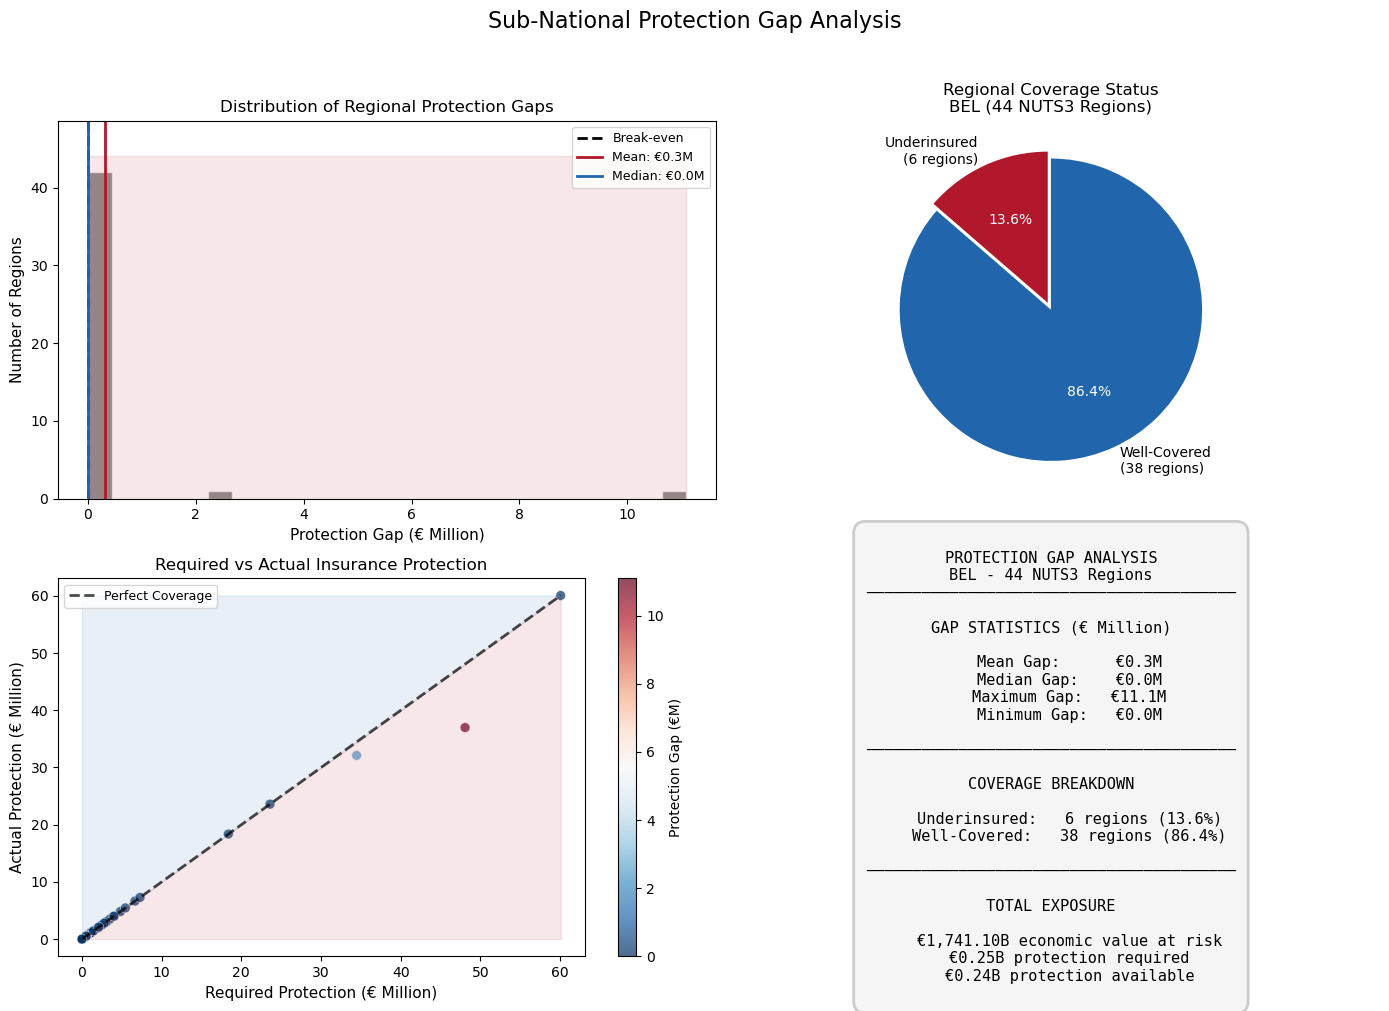

In [62]:
# Calculate Protection Gap
# Gap = Expected Losses - Insurance Capacity to Absorb Losses

# Use existing df_eal data
df_gap = df_eal.copy()

# Required protection = Expected Annual Loss (what we expect to lose from disasters)
df_gap['required_protection'] = df_gap['expected_annual_loss']

# Actual protection = Insurance capacity to absorb losses
# For a healthy market (combined ratio < 100%), insurers can cover all expected losses
# For a stressed market (combined ratio > 100%), capacity is reduced proportionally
# Capacity factor: if CR=80%, market is healthy (factor=1.25); if CR=120%, market is stressed (factor=0.83)
# We use: capacity_factor = 1 / combined_ratio (capped at 1.0 for very healthy markets)
capacity_factor = np.minimum(1.0, 1.0 / df_gap['regional_combined_ratio'])
df_gap['actual_protection'] = df_gap['expected_annual_loss'] * capacity_factor

# Protection gap (positive = underinsured, negative = well-covered)
# Gap > 0: EAL exceeds what insurance can cover
# Gap < 0: Insurance capacity exceeds expected losses
df_gap['protection_gap'] = df_gap['required_protection'] - df_gap['actual_protection']

# Normalize for bivariate visualization (0-1 scale)
df_gap['exposure_normalized'] = (df_gap['total_exposure'] - df_gap['total_exposure'].min()) / \
                                 (df_gap['total_exposure'].max() - df_gap['total_exposure'].min())

df_gap['hazard_normalized'] = df_gap['vulnerability_factor']  # Already 0-1 scale

# Visualize Protection Gap Analysis

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calculate statistics
gap_mean = df_gap['protection_gap'].mean() / 1e6
gap_median = df_gap['protection_gap'].median() / 1e6
gap_max = df_gap['protection_gap'].max() / 1e6
gap_min = df_gap['protection_gap'].min() / 1e6
n_underinsured = (df_gap['protection_gap'] > 0).sum()
n_wellcovered = (df_gap['protection_gap'] <= 0).sum()

# Plot 1: Protection Gap Distribution (Histogram)
ax1 = axes[0, 0]
gap_values = df_gap['protection_gap'] / 1e6
colors = ['#b2182b' if x > 0 else '#2166ac' for x in gap_values]
ax1.hist(gap_values, bins=25, color='#636363', edgecolor='white', alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Break-even')
ax1.axvline(x=gap_mean, color='#b2182b', linestyle='-', linewidth=2, label=f'Mean: €{gap_mean:.1f}M')
ax1.axvline(x=gap_median, color='#2166ac', linestyle='-', linewidth=2, label=f'Median: €{gap_median:.1f}M')
ax1.set_xlabel('Protection Gap (€ Million)', fontsize=11)
ax1.set_ylabel('Number of Regions', fontsize=11)
ax1.set_title('Distribution of Regional Protection Gaps', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.fill_betweenx([0, ax1.get_ylim()[1]], 0, gap_values.max(), alpha=0.1, color='#b2182b')
ax1.fill_betweenx([0, ax1.get_ylim()[1]], gap_values.min(), 0, alpha=0.1, color='#2166ac')

# Plot 2: Coverage Status (Pie Chart)
ax2 = axes[0, 1]
sizes = [n_underinsured, n_wellcovered]
labels = [f'Underinsured\n({n_underinsured} regions)', f'Well-Covered\n({n_wellcovered} regions)']
colors_pie = ['#b2182b', '#2166ac']
explode = (0.05, 0)
wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                                    autopct='%1.1f%%', startangle=90, 
                                    textprops={'fontsize': 10})
autotexts[0].set_color('white')
autotexts[1].set_color('white')
ax2.set_title(f'Regional Coverage Status\n{ISO_A3_COUNTRY_CODE} ({len(df_gap)} NUTS3 Regions)', 
              fontsize=12)

# Plot 3: Required vs Actual Protection (Scatter)
ax3 = axes[1, 0]
scatter = ax3.scatter(
    df_gap['required_protection'] / 1e6, 
    df_gap['actual_protection'] / 1e6,
    c=df_gap['protection_gap'] / 1e6,
    cmap='RdBu_r',
    alpha=0.7,
    s=50,
    edgecolor='white',
    linewidth=0.5
)
# Add diagonal line (perfect coverage)
max_val = max(df_gap['required_protection'].max(), df_gap['actual_protection'].max()) / 1e6
ax3.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect Coverage', alpha=0.7)
ax3.set_xlabel('Required Protection (€ Million)', fontsize=11)
ax3.set_ylabel('Actual Protection (€ Million)', fontsize=11)
ax3.set_title('Required vs Actual Insurance Protection', fontsize=12)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Protection Gap (€M)', fontsize=10)
ax3.legend(loc='upper left', fontsize=9)
# Shade regions
ax3.fill_between([0, max_val], [0, max_val], [max_val, max_val], alpha=0.1, color='#2166ac', label='Over-covered')
ax3.fill_between([0, max_val], [0, 0], [0, max_val], alpha=0.1, color='#b2182b', label='Under-covered')

# Plot 4: Summary Statistics (Text Panel)
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text box
summary_text = f"""
PROTECTION GAP ANALYSIS
{ISO_A3_COUNTRY_CODE} - {len(df_gap)} NUTS3 Regions
{'─' * 40}

GAP STATISTICS (€ Million)

    Mean Gap:      €{gap_mean:,.1f}M
    Median Gap:    €{gap_median:,.1f}M
    Maximum Gap:   €{gap_max:,.1f}M
    Minimum Gap:   €{gap_min:,.1f}M

{'─' * 40}

COVERAGE BREAKDOWN

    Underinsured:   {n_underinsured:,} regions ({n_underinsured/len(df_gap)*100:.1f}%)
    Well-Covered:   {n_wellcovered:,} regions ({n_wellcovered/len(df_gap)*100:.1f}%)

{'─' * 40}

TOTAL EXPOSURE

    €{df_gap['total_exposure'].sum()/1e9:,.2f}B economic value at risk
    €{df_gap['required_protection'].sum()/1e9:,.2f}B protection required
    €{df_gap['actual_protection'].sum()/1e9:,.2f}B protection available
"""

ax4.text(0.5, 0.5, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.8', facecolor='#f5f5f5', edgecolor='#cccccc', linewidth=2))

plt.suptitle('Sub-National Protection Gap Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(f"renderings/protection_gap_analysis_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

The bivariate heatmap below visualizes the protection gap by encoding the two key dimensions that create insurance shortfalls. The horizontal axis represents Expected Annual Loss (EAL), showing which regions face the highest potential disaster losses. The vertical axis represents Insurance Market Stress, derived from the regional combined ratio where values above 100% indicate a stressed market with limited capacity.

The color scheme reflects the protection gap concept directly. Green regions (bottom-left) have low expected losses and healthy insurance markets. Yellow regions (bottom-right) have high expected losses but healthy markets that can absorb them. Orange regions (top-left) have low losses but stressed markets. Dark red regions (top-right) represent the true protection gap: high expected losses combined with stressed insurance markets that cannot absorb them. These red regions are where disasters would cause the greatest uninsured economic damage.

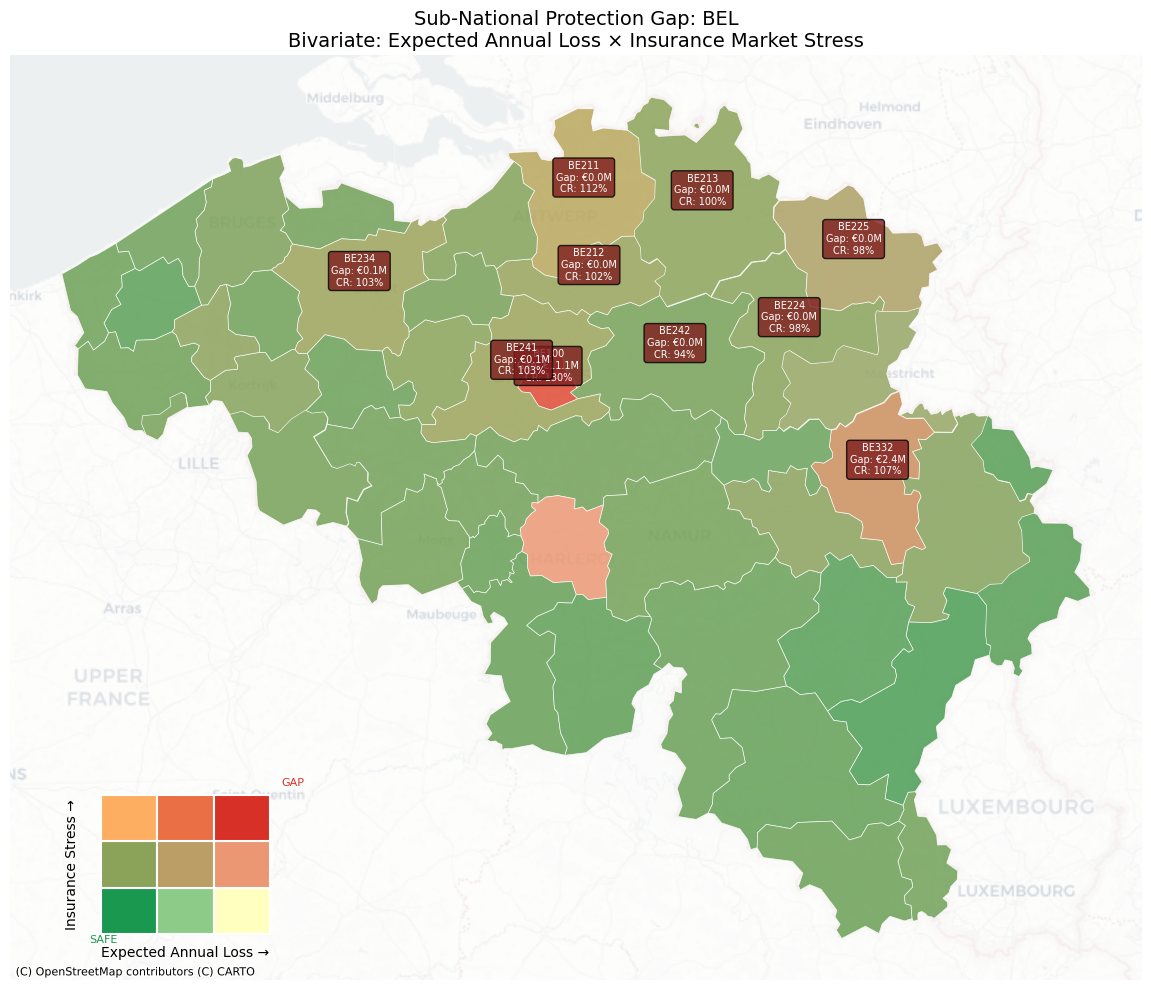

In [63]:
# Create Bivariate Heatmap for Protection Gap
# Two dimensions: Expected Annual Loss (EAL) and Insurance Market Stress

# Add normalized fields for the bivariate map
# Dimension 1: Expected Annual Loss (normalized 0-1)
df_gap['eal_normalized'] = (df_gap['expected_annual_loss'] - df_gap['expected_annual_loss'].min()) / \
                            (df_gap['expected_annual_loss'].max() - df_gap['expected_annual_loss'].min())

# Dimension 2: Insurance Market Stress (based on combined ratio)
# CR < 100% = healthy (low stress), CR > 100% = stressed (high stress)
# Normalize: 0 = best case (CR=70%), 1 = worst case (CR=130%)
cr_min, cr_max = 0.70, 1.30  # Define stress range
df_gap['insurance_stress_normalized'] = np.clip(
    (df_gap['regional_combined_ratio'] - cr_min) / (cr_max - cr_min), 
    0, 1
)

def bivariate_color(eal_norm, stress_norm):
    """
    Creates bivariate color based on normalized EAL and insurance stress.
    
    Corner colors (protection gap perspective):
    - Low EAL, Low Stress: Green (#1a9850) - Low risk, healthy market
    - High EAL, Low Stress: Yellow (#ffffbf) - High risk but market can absorb
    - Low EAL, High Stress: Orange (#fdae61) - Low risk but market stressed
    - High EAL, High Stress: Dark Red (#d73027) - High risk AND market stressed = GAP
    """
    # Define corner colors (RGB normalized 0-1)
    low_low = (0.102, 0.596, 0.314)      # #1a9850 - Green (safe)
    high_eal_low_stress = (1.0, 1.0, 0.749)  # #ffffbf - Yellow (risk but covered)
    low_eal_high_stress = (0.992, 0.682, 0.380)  # #fdae61 - Orange (stressed market)
    high_high = (0.843, 0.188, 0.153)    # #d73027 - Dark red (protection gap!)
    
    # Bilinear interpolation between corners
    low_stress_color = tuple(
        low_low[i] * (1 - eal_norm) + high_eal_low_stress[i] * eal_norm
        for i in range(3)
    )
    high_stress_color = tuple(
        low_eal_high_stress[i] * (1 - eal_norm) + high_high[i] * eal_norm
        for i in range(3)
    )
    
    final_color = tuple(
        low_stress_color[i] * (1 - stress_norm) + high_stress_color[i] * stress_norm
        for i in range(3)
    )
    
    return final_color

# Merge with geometry
gdf_gap = gdf_nuts3_country.merge(df_gap, left_on='NUTS_ID', right_on='nuts_code', how='inner')

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot each region with bivariate color
for idx, row in gdf_gap.iterrows():
    color = bivariate_color(row['eal_normalized'], row['insurance_stress_normalized'])
    gdf_gap.loc[[idx]].plot(ax=ax, color=color, edgecolor='white', linewidth=0.5, alpha=0.85)

# Add basemap
ctx.add_basemap(ax, crs=gdf_gap.crs.to_string(), source=ctx.providers.CartoDB.Positron, alpha=0.4)

# Label top 10 protection gap regions
top_gaps = gdf_gap.nlargest(10, 'protection_gap')
for idx, row in top_gaps.iterrows():
    centroid = row.geometry.centroid
    gap_m = row['protection_gap'] / 1e6
    cr_pct = row['regional_combined_ratio'] * 100
    ax.annotate(
        f"{row['NUTS_ID']}\nGap: €{gap_m:.1f}M\nCR: {cr_pct:.0f}%",
        xy=(centroid.x, centroid.y),
        fontsize=7,
        ha='center',
        color='white',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#7f1d1d', alpha=0.8)
    )

ax.set_title(f'Sub-National Protection Gap: {ISO_A3_COUNTRY_CODE}\nBivariate: Expected Annual Loss × Insurance Market Stress', 
             fontsize=14)
ax.axis('off')

# Create bivariate legend
legend_x = 0.08
legend_y = 0.05
legend_size = 0.15

n_classes = 3
for i in range(n_classes):
    for j in range(n_classes):
        eal_val = i / (n_classes - 1)
        stress_val = j / (n_classes - 1)
        color = bivariate_color(eal_val, stress_val)
        
        rect = plt.Rectangle(
            (legend_x + i * legend_size / n_classes, legend_y + j * legend_size / n_classes),
            legend_size / n_classes,
            legend_size / n_classes,
            transform=ax.transAxes,
            facecolor=color,
            edgecolor='white',
            linewidth=1.5
        )
        ax.add_patch(rect)

# Add legend labels
ax.text(legend_x + legend_size / 2, legend_y - 0.025, 'Expected Annual Loss →', 
        transform=ax.transAxes, ha='center', fontsize=10)
ax.text(legend_x - 0.025, legend_y + legend_size / 2, 'Insurance Stress →', 
        transform=ax.transAxes, ha='center', fontsize=10, rotation=90, va='center')

# Add corner labels for clarity
ax.text(legend_x - 0.01, legend_y - 0.01, 'SAFE', transform=ax.transAxes, fontsize=8, color='#1a9850')
ax.text(legend_x + legend_size + 0.01, legend_y + legend_size + 0.01, 'GAP', transform=ax.transAxes, fontsize=8, color='#d73027')

plt.tight_layout()
plt.savefig(f"renderings/protection_gap_bivariate_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

## Vulnerability-Adjusted Economic Exposure Map

This section visualizes economic exposure adjusted by regional socio-economic vulnerability at the cell level. Unlike the aggregated regional analyses presented earlier, this map shows the precise geographic distribution of vulnerability-weighted economic assets at 30-arc-second resolution (approximately 1 km² cells).

The vulnerability-adjusted exposure for each cell is calculated by multiplying the economic exposure value from the LitPop dataset by the regional socio-economic vulnerability factor from the DRMKC Risk Data Hub. This approach combines asset-level economic data with regional vulnerability assessments to identify locations where high-value assets intersect with reduced coping capacity.

$$\text{Vulnerability-Adjusted Exposure} = \text{Economic Exposure (EUR)} \times \text{Vulnerability Factor}$$

The vulnerability factor ranges from 0 to 1, derived from DRMKC socio-economic vulnerability scores (0-10 scale, divided by 10). Higher vulnerability factors indicate regions with reduced capacity to cope with and recover from disasters due to factors such as lower GDP per capita, inadequate infrastructure, limited emergency services, or demographic challenges.

This visualization identifies economic hotspots in vulnerable regions where disasters would have disproportionate impact, enabling targeted investment in resilience measures, insurance penetration, and emergency preparedness.

In [64]:
# Query: Get all economic exposure cells with socio-economic vulnerability for the country
# Vulnerability scores represent regional coping capacity (socio-economic factors),
# NOT hazard-specific risk. LossEvent.hazard_type contains hazard information.
# Optimized to reduce memory usage by:
# 1. Pre-computing vulnerability scores per NUTS3 in a subquery
# 2. Avoiding large intermediate result sets
# 3. Using CALL {} subquery for better memory management

query_vulnerability_exposure_cells = """
// First, compute vulnerability scores per NUTS3 region (reduces cardinality early)
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF*]-(nuts3:Region {level: 3})
WITH nuts3

// Get vulnerability score in a subquery to avoid cartesian explosion
CALL (nuts3) {
    OPTIONAL MATCH (nuts3)-[vul:HAS_VULNERABILITY]->(v:Vulnerability)
    WHERE vul.year IS NOT NULL
    RETURN vul.score AS score, vul.year AS year
    ORDER BY year DESC
    LIMIT 1
}
WITH nuts3, COALESCE(score, 5.0) AS vulnerability_score

// Now join with cells - cardinality is already reduced
MATCH (nuts3)<-[:LOCATED_IN]-(cell:EconomicExposureCell)

RETURN 
    nuts3.nuts_code AS nuts3_code,
    nuts3.name AS nuts3_name,
    cell.lat AS latitude,
    cell.lon AS longitude,
    cell.value * $usd_to_eur AS exposure_eur,
    vulnerability_score,
    vulnerability_score / 10.0 AS vulnerability_factor,
    (cell.value * $usd_to_eur) * (vulnerability_score / 10.0) AS vulnerability_adjusted_exposure
ORDER BY vulnerability_adjusted_exposure DESC
"""

vulnerability_cells = analysis.run_query(query_vulnerability_exposure_cells, {
    'country_code': ISO_A3_COUNTRY_CODE,
    'usd_to_eur': USD_TO_EUR
})

df_vulnerability_cells = pd.DataFrame(vulnerability_cells)

Created 55118 cell polygons


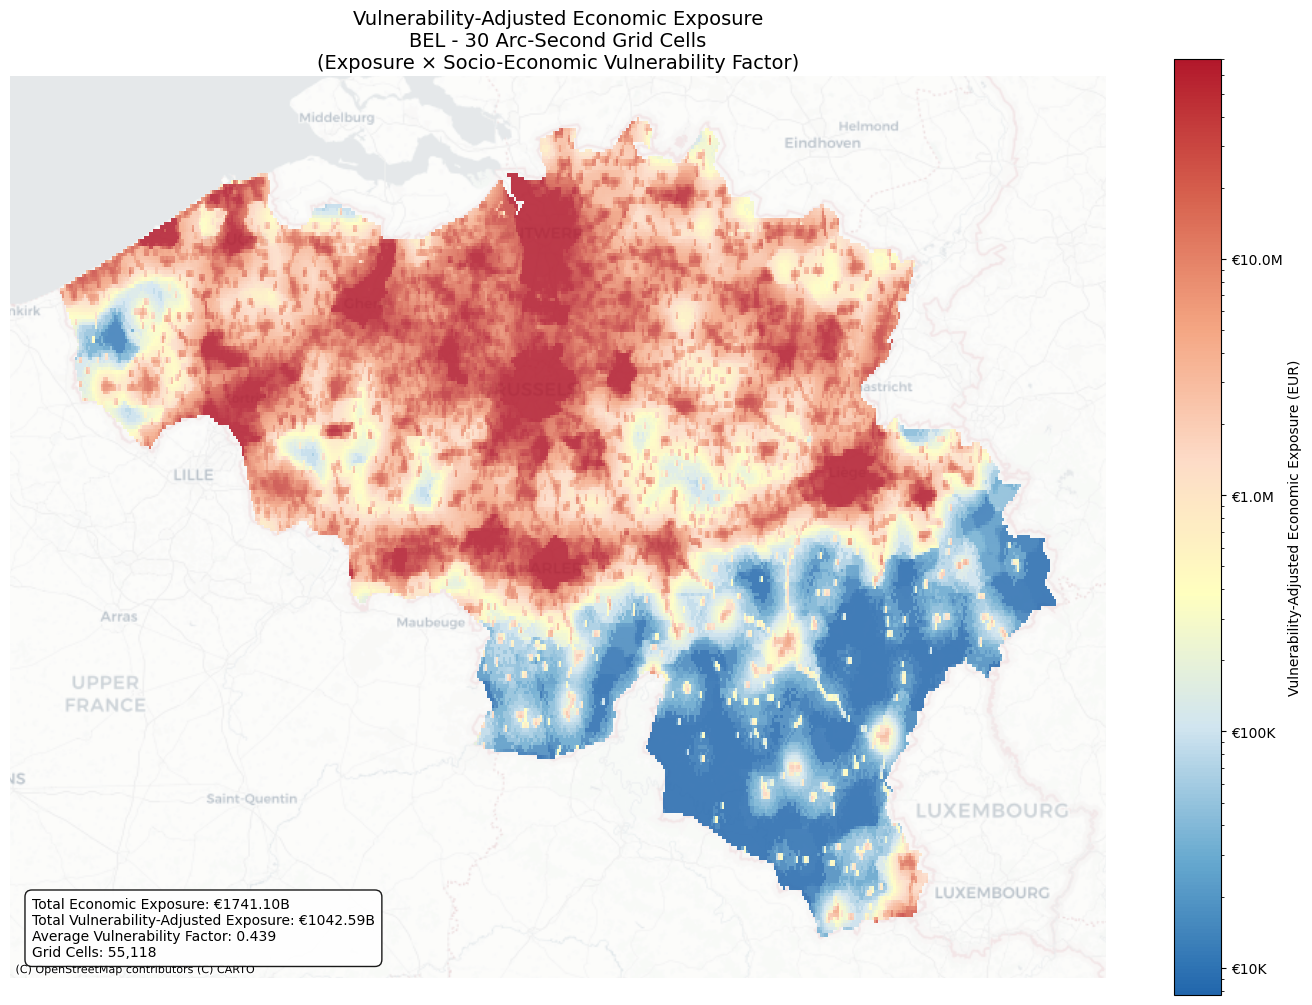

In [65]:
# Create Vulnerability-Adjusted Economic Exposure Cell Map
# Note: Vulnerability here refers to socio-economic vulnerability (coping capacity),
# NOT hazard-specific risk like flood or earthquake probability.

# Convert Points to 30-arc-second Polygons
# 30 arc-seconds = 30/3600 degrees = 1/120 degrees ≈ 0.008333 degrees
cell_size = 1 / 120

# Create GeoDataFrame with cell polygons using the analysis helper
gdf_vulnerability_cells = analysis.create_cell_polygons(
    df_vulnerability_cells, 
    lat_col='latitude', 
    lon_col='longitude', 
    cell_size=cell_size
)

# Convert to Web Mercator for basemap compatibility
gdf_vulnerability_cells = gdf_vulnerability_cells.to_crs(epsg=3857)

print(f"Created {len(gdf_vulnerability_cells)} cell polygons")

# Create the map
fig, ax = plt.subplots(figsize=(14, 12))

# Plot cells with vulnerability-adjusted exposure
# Use logarithmic scale for better color distribution
vmin = gdf_vulnerability_cells['vulnerability_adjusted_exposure'].quantile(0.05)
vmax = gdf_vulnerability_cells['vulnerability_adjusted_exposure'].quantile(0.95)

# Use the standard risk colormap from the analysis helper
cmap = analysis.get_risk_cmap()

gdf_vulnerability_cells.plot(
    column='vulnerability_adjusted_exposure',
    ax=ax,
    cmap=cmap,
    norm=LogNorm(vmin=max(vmin, 1), vmax=vmax),
    legend=True,
    legend_kwds={
        'label': "Vulnerability-Adjusted Economic Exposure (EUR)",
        'format': ticker.FuncFormatter(analysis.currency_fmt),
        'shrink': 0.8
    },
    alpha=0.85,
    edgecolor='none'
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.6)

# Add title
ax.set_title(
    f"Vulnerability-Adjusted Economic Exposure\n{ISO_A3_COUNTRY_CODE} - 30 Arc-Second Grid Cells\n(Exposure × Socio-Economic Vulnerability Factor)",
    fontsize=14
)
ax.set_axis_off()

# Add statistics annotation
total_exposure = gdf_vulnerability_cells['exposure_eur'].sum()
total_adjusted_exposure = gdf_vulnerability_cells['vulnerability_adjusted_exposure'].sum()
avg_vulnerability = gdf_vulnerability_cells['vulnerability_factor'].mean()

stats_text = (
    f"Total Economic Exposure: €{total_exposure/1e9:.2f}B\n"
    f"Total Vulnerability-Adjusted Exposure: €{total_adjusted_exposure/1e9:.2f}B\n"
    f"Average Vulnerability Factor: {avg_vulnerability:.3f}\n"
    f"Grid Cells: {len(gdf_vulnerability_cells):,}"
)
ax.text(
    0.02, 0.02, stats_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.savefig(f"renderings/vulnerability_adjusted_exposure_{ISO_A3_COUNTRY_CODE}.png", bbox_inches='tight')
plt.show()

### How to Read the Vulnerability-Adjusted Exposure Cell Map

This map shows every individual economic exposure cell from LitPop, color-coded by socio-economic vulnerability-adjusted value. The vulnerability factor represents regional coping capacity based on socio-economic indicators such as GDP per capita, infrastructure quality, healthcare access, and emergency response capabilities. This is distinct from hazard-specific risk (like flood probability), which is captured separately in the LossEvent data.

Each cell represents a 30-arc-second grid square at its precise latitude and longitude coordinates. The color intensity reflects the vulnerability-adjusted exposure value, calculated as raw economic exposure multiplied by the regional vulnerability factor.

The color scale ranges from blue/green (low vulnerability-adjusted exposure) through yellow (moderate) to orange and red (high). Dark red regions represent critical areas where high economic value coincides with high socio-economic vulnerability, meaning disasters in these locations would have disproportionate impact due to limited local capacity to cope and recover.

Large red clusters indicate geographic concentrations of vulnerable economic assets, representing systemic risk where a single disaster event could affect multiple high-vulnerability, high-value cells simultaneously. These areas warrant priority attention for resilience building, insurance market development, and emergency preparedness investments.

The statistics panel shows total raw exposure versus vulnerability-adjusted exposure. The ratio between these values indicates the overall vulnerability amplification factor for the country. A higher ratio suggests greater socio-economic vulnerability amplifying the baseline economic risk.

## Risk Community Detection using Graph Algorithms

This section applies graph-based community detection to identify natural clusters of NUTS3 regions with similar risk profiles. By projecting regional data into Neo4j's Graph Data Science (GDS) library, we can leverage the Louvain algorithm to discover groups of regions that share comparable vulnerability and economic exposure characteristics.

The methodology begins by creating a GDS graph projection containing NUTS3 regions as nodes, with vulnerability scores and log-transformed economic exposure as node properties. Since regions do not have inherent connections in the knowledge graph, we use the k-Nearest Neighbors (k-NN) algorithm to create similarity-based relationships. This approach efficiently identifies the most similar regions for each node based on their multi-dimensional risk profile, avoiding the computational expense of comparing all possible region pairs.

Once similarity relationships are established, the Louvain community detection algorithm partitions regions into communities by optimizing modularity. Regions within the same community exhibit similar risk characteristics, making them candidates for portfolio grouping in insurance underwriting, coordinated disaster response planning, or targeted resilience investments. The resulting communities reveal geographic and risk-based patterns that may not be apparent from individual regional analysis alone.

In [66]:
# Create a simplified GDS projection with just nodes
# We'll use k-NN algorithm to efficiently find similar regions instead of comparing all pairs

projection_name = "risk_communities"

# First, check if projection exists and drop it
drop_projection_query = """
CALL gds.graph.exists($projectionName) YIELD exists
"""

result = analysis.run_query_single(drop_projection_query, {"projectionName": projection_name})
exists = result["exists"]

if exists:
    print(f"Dropping existing projection: {projection_name}")
    analysis.run_query("CALL gds.graph.drop($projectionName)", {"projectionName": projection_name})
    print("✓ Existing projection dropped")

# Create projection using the new aggregation function syntax (replaces deprecated gds.graph.project.cypher)
create_projection_query = """
MATCH (country:Country {iso_a3: $country_code})<-[:PART_OF*]-(nuts3:Region {level: 3})
MATCH (nuts3)<-[:LOCATED_IN]-(cell:EconomicExposureCell)
OPTIONAL MATCH (nuts3)-[vul:HAS_VULNERABILITY]->(v:Vulnerability)
WHERE vul.year IS NOT NULL
WITH nuts3, 
     COALESCE(collect(vul.score)[0], 5.0) AS vulnerability_score,
     SUM(cell.value) AS total_exposure
WITH nuts3, vulnerability_score, log(total_exposure + 1) AS log_exposure
WITH gds.graph.project(
    $projectionName,
    nuts3,
    null,
    {
        sourceNodeProperties: {
            vulnerability: vulnerability_score,
            log_exposure: log_exposure
        },
        targetNodeProperties: null
    }
) AS g
RETURN g.graphName AS graphName, g.nodeCount AS nodeCount, g.relationshipCount AS relationshipCount
"""

print(f"Creating graph projection with nodes only...")

record = analysis.run_query_single(create_projection_query, {
    "projectionName": projection_name,
    "country_code": ISO_A3_COUNTRY_CODE
})
print(f"✓ Graph projection created!")
print(f"  Nodes (NUTS3 regions): {record['nodeCount']}")

# Use k-NN to efficiently find similar regions and add relationships
print(f"Finding similar regions using k-NN algorithm...")

knn_query = """
CALL gds.knn.mutate($projectionName, {
    nodeProperties: ['vulnerability', 'log_exposure'],
    topK: 10,
    sampleRate: 1.0,
    deltaThreshold: 0.0,
    concurrency: 1,
    randomSeed: 42,
    mutateRelationshipType: 'SIMILAR',
    mutateProperty: 'score'
})
YIELD nodesCompared, relationshipsWritten
RETURN nodesCompared, relationshipsWritten
"""

record = analysis.run_query_single(knn_query, {"projectionName": projection_name})
print(f"✓ k-NN completed!")
print(f"  Regions compared: {record['nodesCompared']}")
print(f"  Similarity relationships created: {record['relationshipsWritten']}")

Creating graph projection with nodes only...
✓ Graph projection created!
  Nodes (NUTS3 regions): 44
Finding similar regions using k-NN algorithm...
✓ k-NN completed!
  Regions compared: 44
  Similarity relationships created: 440


In [67]:
# Step 3: Run Louvain community detection algorithm

louvain_query = """
CALL gds.louvain.stream($projectionName, {
  relationshipTypes: ['SIMILAR'],
  includeIntermediateCommunities: false
})
YIELD nodeId, communityId
WITH gds.util.asNode(nodeId) AS region, communityId
RETURN 
  region.nuts_code AS nuts_code,
  region.name AS region_name,
  communityId
ORDER BY communityId, nuts_code
"""

print("Running Louvain community detection algorithm...")
print("This algorithm will identify clusters of regions with similar risk profiles.\n")

louvain_records = analysis.run_query(louvain_query, {
    "projectionName": projection_name,
})

df_communities = pd.DataFrame(louvain_records)

print(f"Community detection complete!")
print(f"\nSummary:")
print(f"  Total regions: {len(df_communities)}")
print(f"  Communities found: {df_communities['communityId'].nunique()}")
print(f"\nCommunity sizes:")
community_sizes = df_communities.groupby('communityId').size().sort_values(ascending=False)
for comm_id, size in community_sizes.items():
    print(f"  Community {comm_id}: {size} regions")

print(f"\nSample regions by community:")
print(df_communities.head(15).to_string(index=False))

Running Louvain community detection algorithm...
This algorithm will identify clusters of regions with similar risk profiles.

Community detection complete!

Summary:
  Total regions: 44
  Communities found: 3

Community sizes:
  Community 5: 22 regions
  Community 4: 14 regions
  Community 19: 8 regions

Sample regions by community:
nuts_code                                       region_name  communityId
    BE223                                     Arr. Tongeren            4
    BE225                                      Arr. Maaseik            4
    BE233                                        Arr. Eeklo            4
    BE235                                   Arr. Oudenaarde            4
    BE253                                        Arr. Ieper            4
    BE257                                        Arr. Tielt            4
    BE258                                       Arr. Veurne            4
    BE32A                                          Arr. Ath            4
    BE3

We can now visualize the detected communities. Each color represents a different grouping detected by the Louvain algorithm based on its risk profile.

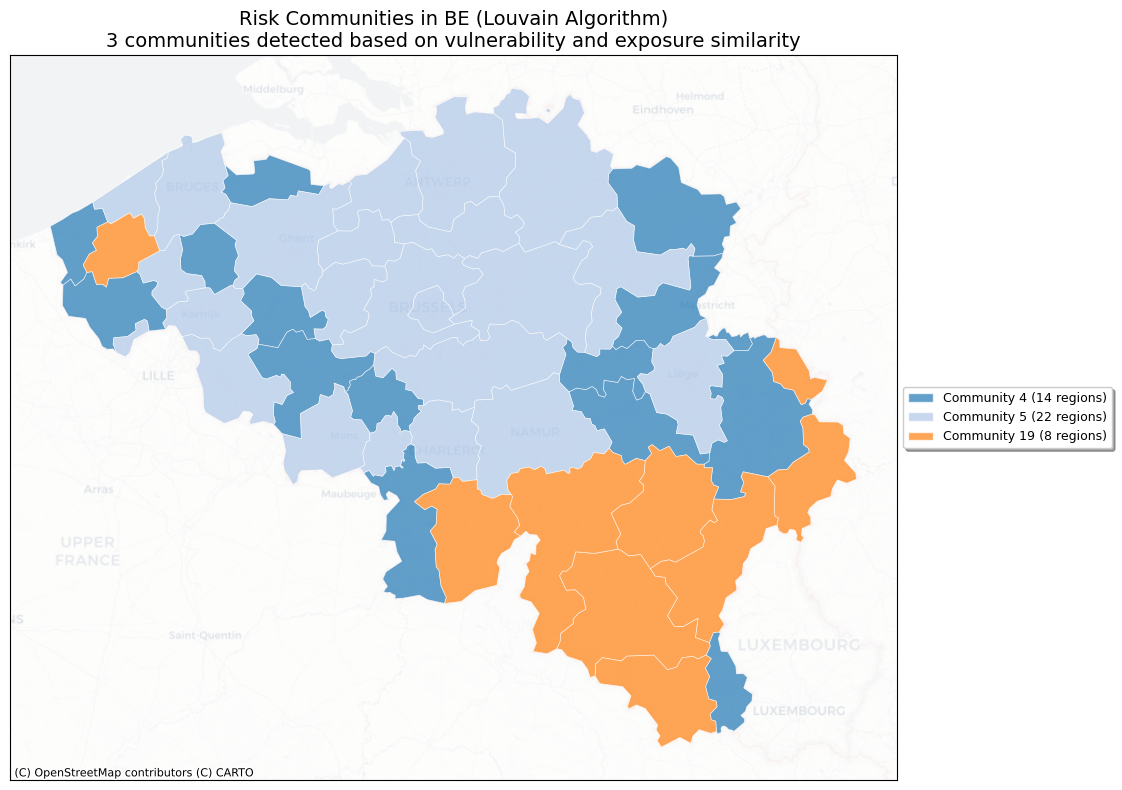

In [68]:
from matplotlib.patches import Patch

# Visualize communities on a map

# Merge community data with geometry
gdf_communities = gdf_nuts3_full.merge(
    df_communities,
    left_on='NUTS_ID',
    right_on='nuts_code',
    how='inner'
)

# Filter to the target country
gdf_communities_country = gdf_communities[
    gdf_communities['CNTR_CODE'] == ISO_A3_COUNTRY_CODE[:2]
]


if len(gdf_communities_country) == 0:
    print("\nNo regions found! Check country codes.")
else:
    # Project to Web Mercator for visualization
    gdf_communities_plot = gdf_communities_country.to_crs('EPSG:3857')

    # Get unique communities present in the filtered data
    unique_communities = sorted(gdf_communities_plot['communityId'].unique())
    num_communities = len(unique_communities)
    colors_palette = plt.cm.tab20(range(num_communities))

    # Create the map
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each community with a different color and store info for legend
    legend_data = []
    for i, comm_id in enumerate(unique_communities):
        gdf_comm = gdf_communities_plot[gdf_communities_plot['communityId'] == comm_id]
        if len(gdf_comm) > 0:
            gdf_comm.plot(
                ax=ax,
                color=colors_palette[i],
                edgecolor='white',
                linewidth=0.5,
                alpha=0.7
            )
            legend_data.append((colors_palette[i], f'Community {comm_id} ({len(gdf_comm)} regions)'))

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.3)

    # Add title and labels
    ax.set_title(
        f'Risk Communities in {ISO_A3_COUNTRY_CODE[:2]} (Louvain Algorithm)\n'
        f'{num_communities} communities detected based on vulnerability and exposure similarity',
        fontsize=14
    )

    # Create manual legend using patches
    legend_elements = [Patch(facecolor=color, edgecolor='white', label=label, alpha=0.7) 
                       for color, label in legend_data]
    ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=9,
        frameon=True,
        fancybox=True,
        shadow=True
    )

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [69]:
# Clean up the graph projection

print(f"Cleaning up graph projection: {projection_name}")

cleanup_query = """
CALL gds.graph.drop($projectionName)
YIELD graphName
RETURN graphName
"""

record = analysis.run_query_single(cleanup_query, {"projectionName": projection_name})
print(f"Graph projection '{record['graphName']}' has been removed from memory")
print("\nGraph Data Science workflow complete!")

Cleaning up graph projection: risk_communities
Graph projection 'risk_communities' has been removed from memory

Graph Data Science workflow complete!
